<a href="https://colab.research.google.com/github/Kenz2000/Unsupervised-learning-project/blob/main/last_clean_version_unsupervised_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Objectifs:**
L’objectif de ce projet est d’utiliser la classification non supervisée pour résumer les variations de la consommation d’´energie de 100 appartements, observée toutes les 30 minutes durant 91 jours consécutifs. Plus spécifiquement, on cherche ici `à obtenir une classification des jours, uniforme pour l’ensemble des appartements. Une telle classification pourra etre utile, par exemple, dans le cadre de la surveillance d’un réseau d'electricité.


**Installation des packages**

In [ ]:
!pip install gap-stat
!pip install fuzzy-c-means
!pip install hdbscan
!pip install -U scikit-learn
!pip install scikit-learn-extra
!pip install tslearn
!pip install minisom
!pip install ruptures

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gap-stat: filename=gap_stat-2.0.3-py3-none-any.whl size=6133 sha256=9c8a0141669998e3e065993bf3476d223cea3e2afb6a74be9fc7af7cadc4097d
  Stored in directory: /root/.cache/pip/wheels/e6/75/de/ee29b366258cdeccdacaff94d895b9d2ffc95a486f3b982441
Successfully built gap-stat
  Attempting uninstall: typer
    Found existing installation: typer 0.9.0
    Uninstalling typer-0.9.0:
      Successfully uninstalled typer-0.9.0
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installe

**Importation des bibliothèques requises**

In [ ]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans ,AgglomerativeClustering, SpectralClustering
from fcmeans import FCM
import hdbscan
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns # Optional, for enhanced styling
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics.pairwise import manhattan_distances
from tslearn.metrics import cdist_dtw
from sklearn.metrics import davies_bouldin_score

In [ ]:
warnings.filterwarnings('ignore')

#**Analyse exploratoire des données**

**Chargement des données**


In [ ]:
X = np.loadtxt("http://allousame.free.fr/mlds/donnees/X.txt", delimiter=" " )
APPART = np.loadtxt("http://allousame.free.fr/mlds/donnees/APPART.txt", delimiter=" " )
JOUR = np.loadtxt("http://allousame.free.fr/mlds/donnees/JOUR.txt", delimiter=" " )

**Dimension de X**

In [ ]:
df=pd.DataFrame(X)
df.shape

(9100, 48)

**Affichage de X**

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,-1.786785,-1.759306,-1.731826,-1.657497,-1.504801,-1.303554,-1.099353,-0.939600,-0.834307,-0.642136,...,1.796293,1.746644,1.617929,1.374530,0.991029,0.564313,0.200768,-0.077526,-0.276923,-0.433195
1,-0.394478,-0.634234,-0.873990,-1.012224,-0.992106,-0.935577,-0.966903,-1.040886,-1.074217,-1.000619,...,0.835603,0.970470,1.115326,1.143106,0.943505,0.560883,0.094956,-0.287792,-0.456911,-0.492853
2,-1.216742,-1.395422,-1.574103,-1.741657,-1.879992,-1.943143,-1.897188,-1.784239,-1.650855,-1.485354,...,1.153940,1.267196,1.333831,1.347890,1.308287,1.199404,1.006899,0.736046,0.401007,0.031883
3,-0.796512,-1.189678,-1.582845,-1.883616,-2.029875,-2.080617,-2.097591,-2.032449,-1.835092,-1.558510,...,1.156785,1.309893,1.248746,1.033263,0.756840,0.522058,0.398940,0.318105,0.197855,0.046630
4,-0.077746,-0.709023,-1.340300,-1.873472,-2.216010,-2.297673,-2.089215,-1.703073,-1.269871,-0.851312,...,1.526477,1.661399,1.647645,1.470649,1.130163,0.676563,0.177488,-0.281004,-0.634296,-0.921962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9095,-1.373892,-1.611674,-1.849456,-2.037723,-2.138310,-2.158456,-2.107608,-1.958650,-1.691850,-1.353598,...,0.529951,0.485765,0.556992,0.652746,0.672439,0.626687,0.549977,0.461084,0.372155,0.284557
9096,-1.061133,-1.326168,-1.591203,-1.909054,-2.301337,-2.664871,-2.876890,-2.861083,-2.578586,-2.093864,...,0.998410,1.241800,1.266223,1.095714,0.790980,0.405643,0.011605,-0.239013,-0.229034,-0.061260
9097,-0.703021,-0.931821,-1.160621,-1.357542,-1.493810,-1.553057,-1.536860,-1.506154,-1.502012,-1.426687,...,1.005878,0.941988,0.802163,0.677693,0.636938,0.584028,0.414505,0.153798,-0.147069,-0.464579
9098,-0.687142,-0.963776,-1.240411,-1.459325,-1.576649,-1.603905,-1.569288,-1.512294,-1.474450,-1.494115,...,0.660649,0.686355,0.658493,0.573240,0.422843,0.215098,-0.032531,-0.279474,-0.491025,-0.679058


**Données d'appartements**

In [ ]:
df_app=pd.DataFrame(APPART)

In [ ]:
df_app.shape

(9100, 1)

**Données des jours**

In [ ]:
df_jours=pd.DataFrame(JOUR)

In [ ]:
df_jours.shape

(9100, 1)

**Concaténation des trois tableaux : X, appartements, et tableau des jours**

In [ ]:
data=df.copy()
data['Appart']=df_app[0]
data['Jour']=df_jours[0]
data

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,Appart,Jour
0,-1.786785,-1.759306,-1.731826,-1.657497,-1.504801,-1.303554,-1.099353,-0.939600,-0.834307,-0.642136,...,1.617929,1.374530,0.991029,0.564313,0.200768,-0.077526,-0.276923,-0.433195,1.0,1.0
1,-0.394478,-0.634234,-0.873990,-1.012224,-0.992106,-0.935577,-0.966903,-1.040886,-1.074217,-1.000619,...,1.115326,1.143106,0.943505,0.560883,0.094956,-0.287792,-0.456911,-0.492853,1.0,2.0
2,-1.216742,-1.395422,-1.574103,-1.741657,-1.879992,-1.943143,-1.897188,-1.784239,-1.650855,-1.485354,...,1.333831,1.347890,1.308287,1.199404,1.006899,0.736046,0.401007,0.031883,1.0,3.0
3,-0.796512,-1.189678,-1.582845,-1.883616,-2.029875,-2.080617,-2.097591,-2.032449,-1.835092,-1.558510,...,1.248746,1.033263,0.756840,0.522058,0.398940,0.318105,0.197855,0.046630,1.0,4.0
4,-0.077746,-0.709023,-1.340300,-1.873472,-2.216010,-2.297673,-2.089215,-1.703073,-1.269871,-0.851312,...,1.647645,1.470649,1.130163,0.676563,0.177488,-0.281004,-0.634296,-0.921962,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9095,-1.373892,-1.611674,-1.849456,-2.037723,-2.138310,-2.158456,-2.107608,-1.958650,-1.691850,-1.353598,...,0.556992,0.652746,0.672439,0.626687,0.549977,0.461084,0.372155,0.284557,100.0,87.0
9096,-1.061133,-1.326168,-1.591203,-1.909054,-2.301337,-2.664871,-2.876890,-2.861083,-2.578586,-2.093864,...,1.266223,1.095714,0.790980,0.405643,0.011605,-0.239013,-0.229034,-0.061260,100.0,88.0
9097,-0.703021,-0.931821,-1.160621,-1.357542,-1.493810,-1.553057,-1.536860,-1.506154,-1.502012,-1.426687,...,0.802163,0.677693,0.636938,0.584028,0.414505,0.153798,-0.147069,-0.464579,100.0,89.0
9098,-0.687142,-0.963776,-1.240411,-1.459325,-1.576649,-1.603905,-1.569288,-1.512294,-1.474450,-1.494115,...,0.658493,0.573240,0.422843,0.215098,-0.032531,-0.279474,-0.491025,-0.679058,100.0,90.0


Dans le code ci-desous nous avons créé une nouvelle table où chaque ligne représente un appartement, et les colonnes représentent la consommation d'énergie de chaque appartement sur une période de 91 jours, avec un intervalle de 30 minutes.

In [ ]:
my_ll=[]
for i in range (1,101):
    my_list=[]
    d={}
    m=0
    for day in range(1,92):
          res=data[data['Appart']==i]
          res=res[res['Jour']==day]
          res= res.drop(['Appart','Jour'],axis=1)
          ll=res .to_dict('tight')['data']
          l=[]
          for elem in ll :
            l=l+elem
          my_list=my_list+l
    for elem in my_list:
              d[m]=elem
              m=m+1
    d['Appart']=i
    my_ll.append(d)
data =pd.DataFrame(my_ll)
data

,0,1,2,3,4,5,6,7,8,9,...,4359,4360,4361,4362,4363,4364,4365,4366,4367,Appart
0,-1.786785,-1.759306,-1.731826,-1.657497,-1.504801,-1.303554,-1.099353,-0.939600,-0.834307,-0.642136,...,0.842348,0.743352,0.572553,0.394154,0.236707,0.127456,0.124078,0.266715,0.494930,1
1,-1.696926,-1.589682,-1.482438,-1.438186,-1.504610,-1.668164,-1.880164,-2.012606,-1.950127,-1.707242,...,0.736486,0.683914,0.606173,0.432088,0.194261,-0.057964,-0.312055,-0.565359,-0.817930,2
2,0.152293,-0.001868,-0.156029,-0.260148,-0.283644,-0.273770,-0.282275,-0.301053,-0.309397,-0.296038,...,0.848834,0.797598,0.611185,0.326360,0.000687,-0.303251,-0.523594,-0.621051,-0.645872,3
3,-0.951338,-1.038791,-1.126245,-1.259050,-1.456028,-1.629866,-1.693202,-1.664615,-1.575958,-1.406233,...,0.574832,0.558728,0.570994,0.724730,0.867772,0.837370,0.693679,0.533052,0.373722,4
4,-1.117863,-1.209420,-1.300976,-1.335880,-1.282855,-1.212149,-1.186737,-1.139009,-0.997874,-0.808915,...,0.712476,0.649029,0.493149,0.270269,0.047190,-0.111916,-0.194744,-0.208145,-0.183737,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.476726,-1.384780,-1.292834,-1.316479,-1.520947,-1.770050,-1.916043,-1.966382,-1.949685,-1.824007,...,0.629315,0.769022,0.837379,0.742844,0.522179,0.223564,-0.187463,-0.742874,-1.382051,96
96,-0.147306,-0.628073,-1.108839,-1.478275,-1.658697,-1.707026,-1.701723,-1.672829,-1.605088,-1.350490,...,1.014642,1.108927,1.038618,0.787709,0.439469,0.089793,-0.214186,-0.450071,-0.645637,97
97,-1.459160,-1.487654,-1.516149,-1.488817,-1.382944,-1.308259,-1.363864,-1.473904,-1.517791,-1.370945,...,0.518264,0.741340,0.945640,1.016281,0.891805,0.565214,0.193923,-0.069454,-0.255923,98
98,-1.636396,-1.735798,-1.835200,-1.902854,-1.915313,-1.882320,-1.817190,-1.714326,-1.560443,-1.330420,...,0.291293,0.328930,0.477352,0.680531,0.842687,0.885235,0.838111,0.751590,0.648769,99


Modifier les noms des colonnes (appartements) dans le tableau.

In [ ]:
data=data.drop('Appart',axis=1)
data=data.T
l=[] #liste des appartements
for i in range (1,data.shape[1]+1):
  num_appart="appt_"+str(i)
  l.append(num_appart)
data.columns=l

Affichage du tableau avec les colonnes renommées

In [ ]:
data

,appt_1,appt_2,appt_3,appt_4,appt_5,appt_6,appt_7,appt_8,appt_9,appt_10,...,appt_91,appt_92,appt_93,appt_94,appt_95,appt_96,appt_97,appt_98,appt_99,appt_100
0,-1.786785,-1.696926,0.152293,-0.951338,-1.117863,-0.619164,-1.934051,-1.231540,-0.915803,-0.414599,...,-1.458296,-0.943808,-1.058543,0.094067,-0.551474,-1.476726,-0.147306,-1.459160,-1.636396,-0.587143
1,-1.759306,-1.589682,-0.001868,-1.038791,-1.209420,-0.809750,-1.509850,-1.642594,-0.966073,-0.626387,...,-1.435501,-1.081751,-1.189145,-0.598292,-0.770247,-1.384780,-0.628073,-1.487654,-1.735798,-0.958683
2,-1.731826,-1.482438,-0.156029,-1.126245,-1.300976,-1.000337,-1.085648,-2.053648,-1.016343,-0.838176,...,-1.412706,-1.219694,-1.319748,-1.290650,-0.989019,-1.292834,-1.108839,-1.516149,-1.835200,-1.330222
3,-1.657497,-1.438186,-0.260148,-1.259050,-1.335880,-1.216261,-0.803368,-2.301650,-1.110622,-0.999818,...,-1.436107,-1.420951,-1.482136,-1.813262,-1.223024,-1.316479,-1.478275,-1.488817,-1.902854,-1.661032
4,-1.504801,-1.504610,-0.283644,-1.456028,-1.282855,-1.465663,-0.755584,-2.273051,-1.274301,-1.079398,...,-1.532445,-1.707280,-1.683049,-2.036025,-1.482356,-1.520947,-1.658697,-1.382944,-1.915313,-1.914792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,0.236707,0.194261,0.000687,0.867772,0.047190,-0.297874,0.550373,0.811619,0.150331,-0.183389,...,0.416851,0.033706,0.499871,0.114796,0.189758,0.522179,0.439469,0.891805,0.842687,0.782792
4364,0.127456,-0.057964,-0.303251,0.837370,-0.111916,-0.283077,0.375446,0.607844,-0.135056,-0.165680,...,0.228030,-0.097059,0.441867,-0.138609,0.075995,0.223564,0.089793,0.565214,0.885235,0.545727
4365,0.124078,-0.312055,-0.523594,0.693679,-0.194744,-0.176180,0.155209,0.307500,-0.440554,-0.032473,...,0.024460,-0.280254,0.198932,-0.416507,-0.026878,-0.187463,-0.214186,0.193923,0.838111,0.173050
4366,0.266715,-0.565359,-0.621051,0.533052,-0.208145,-0.101958,-0.124331,-0.097942,-0.696609,0.210857,...,-0.093487,-0.574358,-0.234762,-0.680007,-0.073983,-0.742874,-0.450071,-0.069454,0.751590,-0.305220


Intégration de la colonne "Time" au sein du tableau Data

In [ ]:
data.insert(0, 'Time', pd.date_range(start='1/1/2023', periods=len(data), freq='30min'))
data.head()

,Time,appt_1,appt_2,appt_3,appt_4,appt_5,appt_6,appt_7,appt_8,appt_9,...,appt_91,appt_92,appt_93,appt_94,appt_95,appt_96,appt_97,appt_98,appt_99,appt_100
0,2023-01-01 00:00:00,-1.786785,-1.696926,0.152293,-0.951338,-1.117863,-0.619164,-1.934051,-1.231540,-0.915803,...,-1.458296,-0.943808,-1.058543,0.094067,-0.551474,-1.476726,-0.147306,-1.459160,-1.636396,-0.587143
1,2023-01-01 00:30:00,-1.759306,-1.589682,-0.001868,-1.038791,-1.209420,-0.809750,-1.509850,-1.642594,-0.966073,...,-1.435501,-1.081751,-1.189145,-0.598292,-0.770247,-1.384780,-0.628073,-1.487654,-1.735798,-0.958683
2,2023-01-01 01:00:00,-1.731826,-1.482438,-0.156029,-1.126245,-1.300976,-1.000337,-1.085648,-2.053648,-1.016343,...,-1.412706,-1.219694,-1.319748,-1.290650,-0.989019,-1.292834,-1.108839,-1.516149,-1.835200,-1.330222
3,2023-01-01 01:30:00,-1.657497,-1.438186,-0.260148,-1.259050,-1.335880,-1.216261,-0.803368,-2.301650,-1.110622,...,-1.436107,-1.420951,-1.482136,-1.813262,-1.223024,-1.316479,-1.478275,-1.488817,-1.902854,-1.661032
4,2023-01-01 02:00:00,-1.504801,-1.504610,-0.283644,-1.456028,-1.282855,-1.465663,-0.755584,-2.273051,-1.274301,...,-1.532445,-1.707280,-1.683049,-2.036025,-1.482356,-1.520947,-1.658697,-1.382944,-1.915313,-1.914792


**La visualisation des séries temporelles**

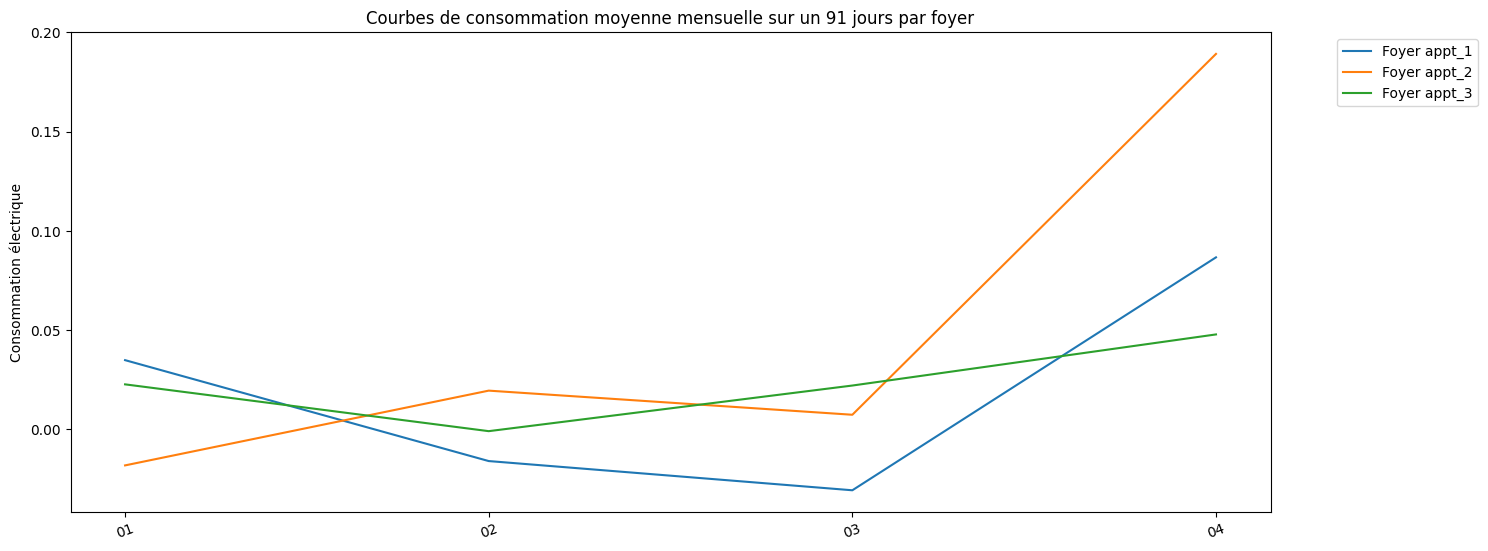

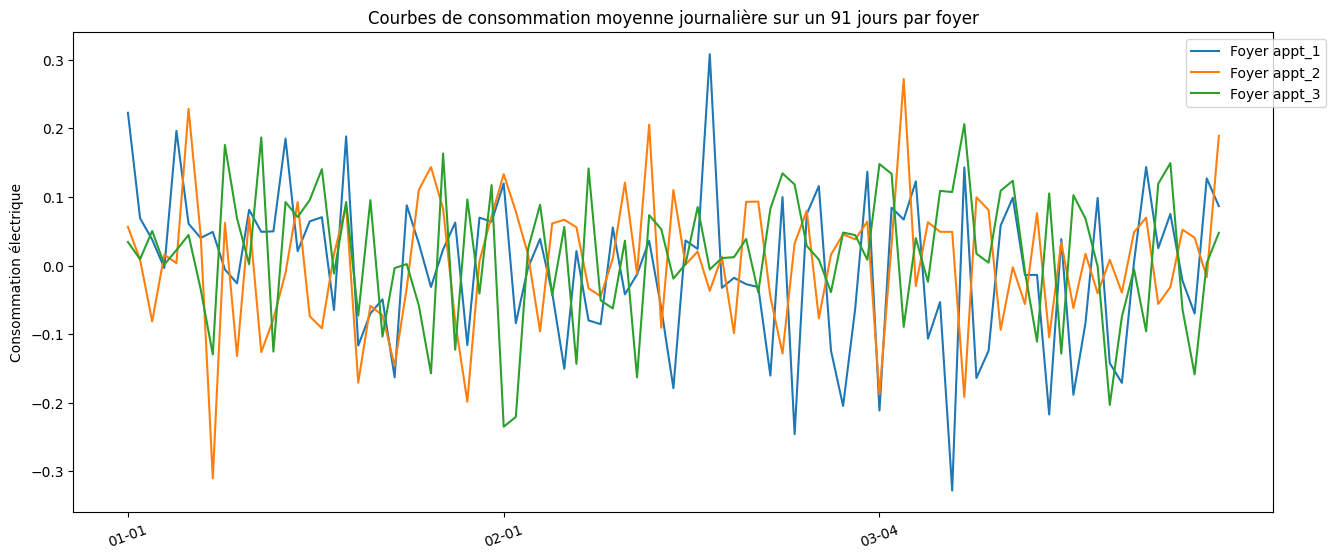

In [ ]:
def graph_consos(DataFrame, time , liste_profils):
    x = DataFrame.copy()
    temp = data.copy()
    #On utilise la fonction copy pour ne pas modifier le DataFrame considéré
    if time == 'Month':
        k = 7 #mois
        s = 1
        mode = 'mensuelle'
    else:
        k = 10 #jours
        s = 31
        mode = 'journalière'

    temp[time] = temp["Time"].astype('str').str[5:k]
    temp = temp.groupby(time).mean()
    x[time] = x['Time'].astype('str').str[5:k]
    x = x.groupby(time).mean()

    fig = plt.figure(figsize = [12, 4.8])
    a1 = fig.add_axes([0,0,1,1])
    a1.set_ylabel('Consommation électrique')
    #calendar.month_name[1:6]+calendar.month_name[7:12],
    plt.xticks(np.arange(len(x), step = s),  rotation=20)
    plt.title('Courbes de consommation moyenne %s sur un 91 jours par foyer' % mode)

    for profil in liste_profils:
        plt.plot(x[profil], label= 'Foyer %s' % profil) #boucle if qui permet de toujours avoir une belle légende

    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()
graph_consos(data, time = 'Month', liste_profils = ["appt_1", "appt_2", "appt_3"])
graph_consos(DataFrame = data, time='Week', liste_profils = ["appt_1", "appt_2", "appt_3"])

Lorsqu'on agrège les données à une échelle mensuelle/journalière, on peut constater une réduction significative de la variabilité des données. Cependant, cela offre un aperçu des habitudes de consommation des différents ménages et représente une première approche d'agrégation des données. Pour analyser des comportements plus détaillés et subtils, il serait intéressant d'examiner des courbes telles que la consommation quotidienne moyenne de certains ménages.

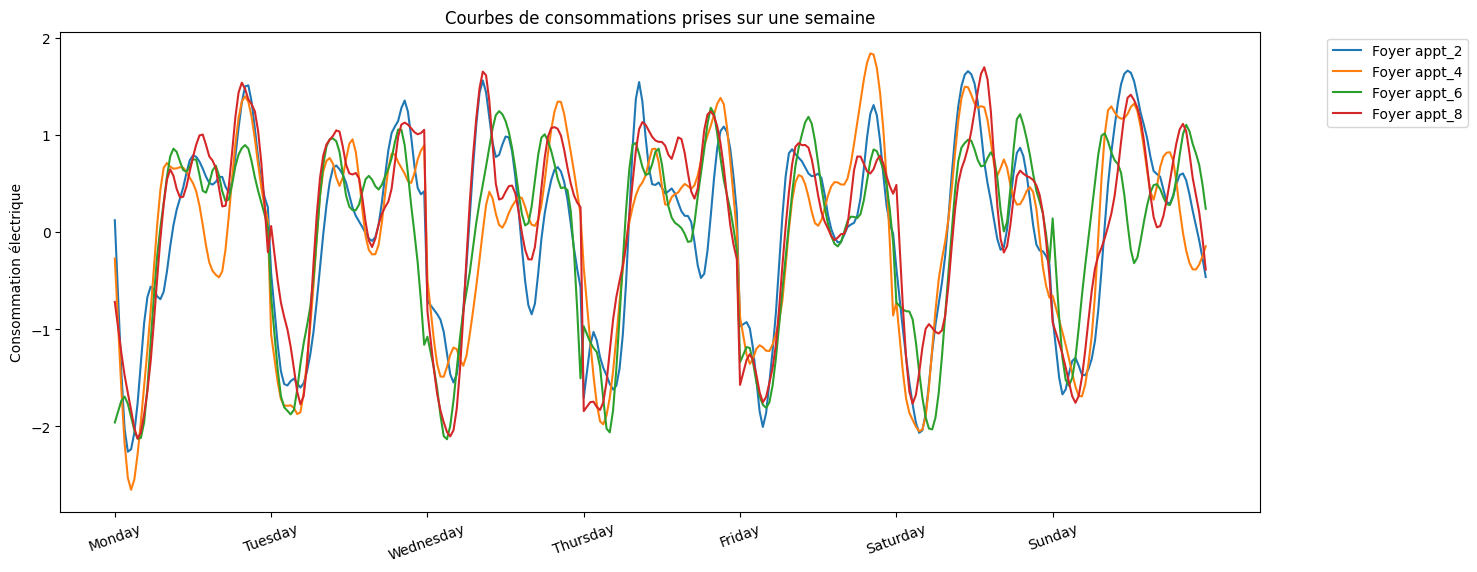

In [ ]:
import calendar
def graph_conso_semaine(DataFrame, liste_profils , semaine , plot):

    x = DataFrame.copy()
    temp = DataFrame.copy()
    x = x.drop(columns = 'Time')
    temp = temp.drop(columns = 'Time')

    n = x.shape[0]

    if semaine > n/(7*48):
        return('Semaine trop grande')
    else :
        init = (semaine-1)*7*48 #7 jours dans la semaine et 48 fois une demi-heure par jour
        end = (init+7*48)
        data = x.iloc[init:end]
        temperature = temp.iloc[init:end]

    if plot == True :
        fig = plt.figure(figsize = [12, 4.8])
        a1 = fig.add_axes([0,0,1,1])
        a1.set_ylabel('Consommation électrique')
        plt.title('Courbes de consommations prises sur une semaine')
        plt.xticks(np.arange(init, end, step = 48), calendar.day_name[0:8], rotation=20)
        for profil in liste_profils:
            plt.plot(data[profil], label= 'Foyer %s' % profil)

        plt.legend(bbox_to_anchor=(1.05, 1))
        return(plt.show())
    else :
        return(pd.DataFrame(data[profil] for profil in liste_profils).transpose().reset_index(drop = True))


graph_conso_semaine(data, ["appt_2", "appt_4", "appt_6",'appt_8'] , 12 , plot= True)

La fonction graphique précédente nous offre une meilleure compréhension des comportements des différents profils. Sur le graphique représentant la consommation au cours d'une semaine donnée, on observe des pics relativement élevés, indiquant une variabilité significative entre les 4 foyers. Notamment, le graphique suggère que l'appartement 8 a des pics de consommation pendant le déjeuner les lundis et jeudis, utilisant également des appareils ménagers. D'un autre côté, l'appartement 4 semble rentrer chez lui seulement le soir, mais avec une consommation plus importante à ce moment-là. Il semble également que l'appartement 6 consomme davantage d'électricité le matin, peut-être en raison de l'utilisation de la télévision ou d'autres appareils matinaux. De manière générale, tous les foyers consomment plus d'énergie électrique le week-end, en particulier le samedi, ce qui pourrait s'expliquer par le fait qu'ils passent plus de temps à la maison pendant le week-end.

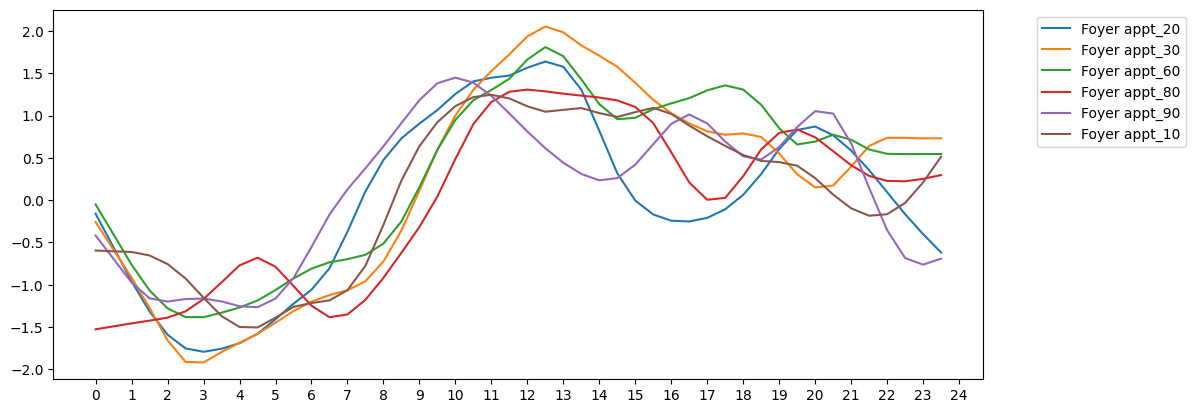

In [ ]:
import datetime
import matplotlib.dates as mdates

liste_des_jours = pd.unique(data['Time'].astype('str').str[5:10])

def valeurs_journee(df, profil, journee):
    df_day = df[df["Time"].astype('str').str[5:10] == journee][profil]
    d1 = pd.DataFrame(df_day).reset_index(drop = True)
    return(d1)

def journee_moyenne(df, profil):
    d1 = valeurs_journee(df, profil, liste_des_jours[0])
    for jour in liste_des_jours[1:]:
        d2 = valeurs_journee(df, profil, jour)
        d1 = pd.concat([d1, d2], axis=1)
    d1 = d1.apply(np.mean, 1)
    return(pd.DataFrame(d2))

def journee_moyenne_liste(df, liste_profils, plot):
    if plot == True:
        fig = plt.figure(figsize = [12, 4.8])
        for profil in liste_profils:
            plt.plot(journee_moyenne(df, profil), label= 'Foyer %s' % profil)
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.xticks(np.arange(0,50, step=2), np.arange(25))
        return(plt.show())

    else :
        d1 = journee_moyenne(df, liste_profils[0])
        for profil in liste_profils[1:]:
            d2 = journee_moyenne(profil)
            d1 = pd.concat([d1, d2], axis = 1)
        return(d1)

journee_moyenne_liste(data, ["appt_20", "appt_30", "appt_60","appt_80", "appt_90", "appt_10"], plot = True)

L'exemple précédent suggère que nos données ne présentent probablement pas une variation importante de la consommation brute entre les individus. Les courbes indiquent qu'il y a un léger dépassement entre la consommation d'un ménage et celle d'un autre, mais les différences de comportement entre les ménages sont visuellement moins évidentes. Cependant, cette observation est basée sur un ensemble restreint de ménages, et rien ne garantit que cela soit le cas pour l'ensemble des données. Afin d'éviter que notre algorithme de clustering identifie la consommation des ménages comme étant beaucoup plus élevée que les autres et de créer des groupes en conséquence, il pourrait être intéressant de normaliser chaque courbe. Cela permettrait de se concentrer sur les différences de comportement, en éliminant l'impact des variations brutes de consommation que l'algorithme de clustering pourrait interpréter de manière incorrecte.

**Diagramme en boîte représentant la consommation d'énergie des appartements toutes les 30 minutes et toutes les heures**

Nous affichons deux séries de temps sous forme de boîtes à moustache : l'une résume la consommation d'énergie des appartements toutes les 30 minutes, et l'autre pour chaque heure.

In [ ]:
df_x_per_hour = pd.DataFrame()
for i in range (24):
    col_name = f'hour_{i+1}'
    df_x_per_hour[col_name] = df.iloc[:, i*2] + df.iloc[:, i*2+1]


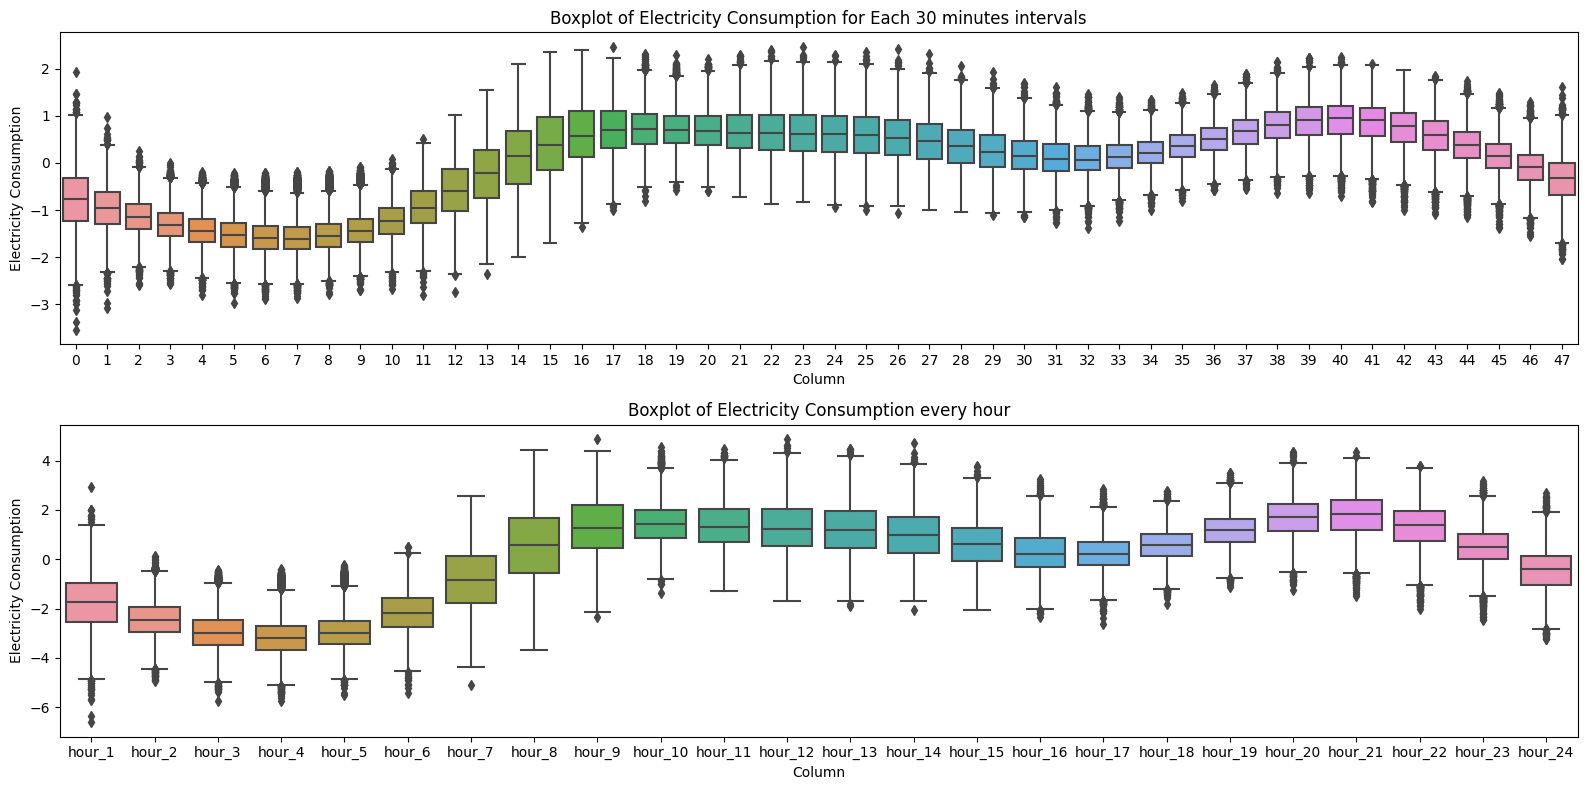

In [ ]:
# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# Boxplot for the first DataFrame (every 30 minutes)
sns.boxplot(data=df, ax=axes[0])
axes[0].set_title('Boxplot of Electricity Consumption for Each 30 minutes intervals')
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Electricity Consumption')
# Boxplot for the second DataFrame (every hour)
sns.boxplot(data=df_x_per_hour, ax=axes[1])
axes[1].set_title('Boxplot of Electricity Consumption every hour')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Electricity Consumption')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#**Partie 1: Transformation du tableau X en un tableau de données catégorielles Y**

Dans cette section, nous avons regroupé les lignes de la table X en K classes. et puis en utilisant les étiquettes des classes, nous avons construit le tableau de données Y, composé de 100 lignes (Appartements) et 91 colonnes (jours).

**Création des méthodes pour determiner la valeur de K (nombre de classes)**

Nous avons employé la méthode du score de silhouette et la méthode du coude pour identifier la valeur optimale de K dans l'algorithme K-means.

**Méthode de score sillouhette**

In [ ]:
# Avec le score sillouhette
def K_silhouette(X,k_max):
  s_scores = [] # liste des valeurs de silhouette pour diférentes valeurs de k
  s_k=[]
  for k in range(2, k_max):
      kmeansT = KMeans(n_clusters=k, verbose=True)
      kmeansT.fit(X)
      labels = kmeansT.labels_
      s_scores.append(silhouette_score(X, labels))
      s_k.append((silhouette_score(X, labels),k))
  #print(s_k)
  # Plot la courbe
  plt.plot(range(2, k_max), s_scores)
  plt.xlabel('Nombre de clusters (K)')
  plt.ylabel('Coefficient de silhouette')
  plt.title('La courbe du coefficient de silhouette')
  plt.show()

**Méthode de score davies bouldin**

In [ ]:
# Avec le score davies bouldin
def davies_bouldin(X,k_max):
  s_scores = [] # liste des valeurs de silhouette pour diférentes valeurs de k
  s_k=[]
  for k in range(2, k_max):
      kmeansT = KMeans(n_clusters=k, verbose=True)
      kmeansT.fit(X)
      labels = kmeansT.labels_
      s_scores.append(davies_bouldin_score(X, labels))
      s_k.append((davies_bouldin_score(X, labels),k))
  #print(s_k)
  # Plot la courbe
  plt.plot(range(2, k_max), s_scores)
  plt.xlabel('Nombre de clusters (K)')
  plt.ylabel('Coefficient de davies bouldin')
  plt.title('La courbe du coefficient de davies bouldin')
  plt.show()

13.114 --> 7.693 --> 7.683 --> 7.681 --> 7.679 --> 7.678 --> 7.677 --> 7.677 --> 7.677 --> 7.677 --> 7.677 --> 7.677 --> 
13.091 --> 7.434 --> 7.187 --> 7.033 --> 6.930 --> 6.853 --> 6.810 --> 6.790 --> 6.780 --> 6.775 --> 6.771 --> 6.770 --> 6.769 --> 6.768 --> 6.768 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 
11.124 --> 6.913 --> 6.408 --> 6.190 --> 6.103 --> 6.011 --> 5.921 --> 5.895 --> 5.890 --> 5.888 --> 5.886 --> 5.885 --> 5.884 --> 5.884 --> 5.884 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 
9.324 --> 5.870 --> 5.527 --> 5.413 --> 5.387 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 
9.006 --> 5.863 --> 5.582 --> 5.371 --> 5.245 --> 5.231 --> 5.228 --> 5.227 --> 5.225 --> 5.223 --> 5.218 --> 5.213 --> 5.207 --> 5.199 --> 5.193 --> 5.189 --> 5.186 --> 5.184 --> 5.1

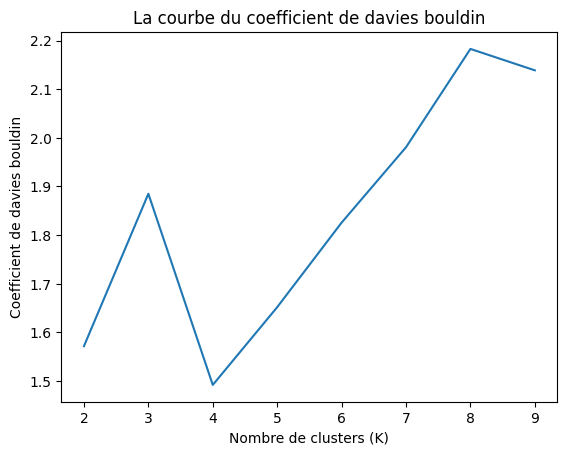

In [ ]:
davies_bouldin(X,10)

D'après la courbe des scores de Davies-Bouldin en relation avec le nombre de clusters, nous observons que le nombre optimal de clusters \(k\) correspond au point le plus bas de la courbe, lequel est situé à \(k=4\).

14.658 --> 7.966 --> 7.782 --> 7.737 --> 7.711 --> 7.696 --> 7.687 --> 7.683 --> 7.681 --> 7.679 --> 7.678 --> 7.677 --> 7.677 --> 7.677 --> 7.677 --> 7.677 --> 7.677 --> 
11.500 --> 6.864 --> 6.781 --> 6.773 --> 6.770 --> 6.769 --> 6.768 --> 6.768 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 6.767 --> 
10.312 --> 6.472 --> 6.280 --> 6.213 --> 6.169 --> 6.127 --> 6.065 --> 5.975 --> 5.899 --> 5.884 --> 5.884 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 5.883 --> 
9.296 --> 6.125 --> 5.986 --> 5.837 --> 5.611 --> 5.451 --> 5.401 --> 5.387 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 
8.181 --> 5.499 --> 5.260 --> 5.182 --> 5.161 --> 5.151 --> 5.140 --> 5.133 --> 5.131 --> 5.130 --> 5.129 --> 5.129 --> 5.129 --> 5.129 --> 5.129 --> 5.129 --> 5.129 --> 5.129 --> 
7.466 --> 5.153 --> 5.034 --> 5.002 --> 4.

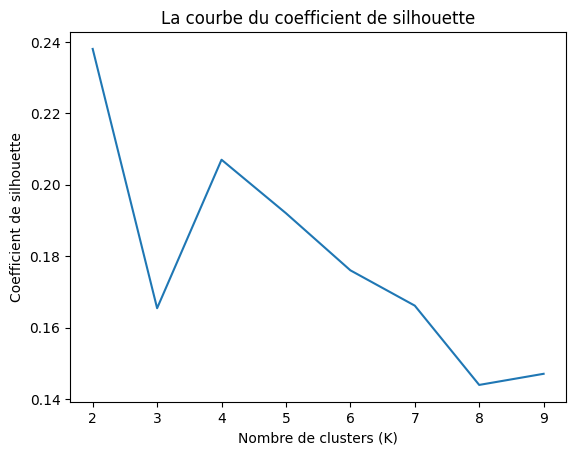

In [ ]:
K_silhouette(X,10)

En analysant la courbe des scores de silhouette en fonction du nombre de clusters, nous remarquons que le nombre de clusters optimal, k, correspond au score de silhouette le plus élevé, qui est de 0.21 et 0.24. Par conséquent, nous pouvons conclure que k=4 serait le nombre de clusters approprié (optimal).

**Méthode de coude (Elbow Method)**

In [ ]:
#méthode de coude
def methode_coude(X,k_max):
  inertia_values = [] # liste des sommes des carrés intra-clusters
  for k in range(2, k_max):
      kmeansT = KMeans(n_clusters=k, verbose=True)
      kmeansT.fit(X)
      #labels = kmeansT.labels_
      inertia_values.append(kmeansT.inertia_)

  # plot
  plt.plot(range(2, k_max), inertia_values)
  plt.xlabel('Nombre de clusters (K)')
  plt.ylabel('inertie intra-classe')
  plt.title('Méthode du coude')
  plt.show()


12.178 --> 7.694 --> 7.686 --> 7.682 --> 7.680 --> 7.679 --> 7.678 --> 7.677 --> 7.677 --> 7.677 --> 7.677 --> 7.677 --> 7.677 --> 
11.434 --> 7.524 --> 7.369 --> 7.303 --> 7.199 --> 7.009 --> 6.840 --> 6.795 --> 6.791 --> 6.791 --> 6.791 --> 6.791 --> 6.791 --> 6.791 --> 6.791 --> 6.791 --> 6.791 --> 
9.817 --> 6.354 --> 6.216 --> 6.203 --> 6.199 --> 6.197 --> 6.196 --> 6.196 --> 6.196 --> 6.195 --> 6.195 --> 6.195 --> 6.194 --> 6.194 --> 6.194 --> 6.194 --> 6.194 --> 6.194 --> 6.194 --> 6.193 --> 6.193 --> 6.193 --> 6.193 --> 6.193 --> 6.193 --> 6.193 --> 6.192 --> 6.192 --> 6.192 --> 6.192 --> 6.192 --> 6.192 --> 6.192 --> 6.192 --> 6.192 --> 6.192 --> 
9.996 --> 6.310 --> 6.085 --> 5.877 --> 5.622 --> 5.437 --> 5.387 --> 5.385 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 5.384 --> 
8.519 --> 6.102 --> 5.499 --> 5.249 --> 5.206 --> 5.197 --> 5.192 --> 5.188 --> 5.185 --> 5.184 --> 5.184 --> 5.183 --> 5.183 --> 5.183 --> 5.183 --> 5.183 --> 5.183 --> 5.18

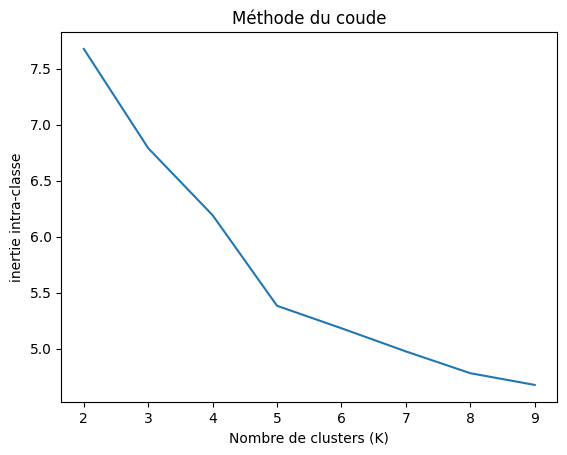

In [ ]:
methode_coude(X,10)

En analysant la courbe de la somme des carrés intra-clusters (WCSS) en fonction du nombre de clusters, nous remarquons un point d'inflexion (le point du coude) au niveau de 4. Cela suggère que 4 serait le nombre de clusters approprié.

**Application des méthodes de clustering sur X**

Nous utilisons divers algorithmes de regroupement tels que K-means, k-meansTimeSeries, Hdbscan, Kmedoid, fuzzy kmeans, spherical kmeans, et l'algorithme de CAH avec différents critères (Ward, complète, average, single).

In [ ]:
def eval_clustering(x, pred_labels, methods):
    fig, axes = plt.subplots(int((len(pred_labels)+1)/3) if not (len(pred_labels)+1)%3 else int((len(pred_labels)+1)/3+1) , 3, figsize=(20,25))
    axes = [item for sublist in axes for item in sublist]
    results = {}
    for i in range(len(pred_labels)):
        calinski=metrics.calinski_harabasz_score(x, pred_labels[i])
        silouhette= silhouette_score(x, pred_labels[i])
        results[methods[i]] = (calinski,silouhette)
        axes[i+1].scatter(x[:,0], x[:,1],
                    c=pred_labels[i], edgecolor='none', alpha=1,)
        axes[i+1].title.set_text(f'{methods[i]}\ncalinski_harabasz_score ={calinski}\n silouhette={silouhette}')
    plt.show()

    return results

In [ ]:
def run_clustering(X, k):
    kmeans_labels = KMeans(k, random_state=42).fit(X).labels_
    TS_Kmeans_labels=TimeSeriesKMeans(n_clusters=k, verbose=True).fit(X).labels_
    TS_kmeansDTW_labels = TimeSeriesKMeans(n_clusters=k, metric='dtw', verbose=True).fit(X).labels_
    hdbscan_labels = hdbscan.HDBSCAN(algorithm="best", alpha=1.0, leaf_size=40, cluster_selection_method="eom", metric="euclidean").fit(X).labels_
    cah_labels_ward = AgglomerativeClustering(n_clusters=k).fit_predict(X)
    cah_labels_complete = AgglomerativeClustering(n_clusters=k, linkage="complete").fit_predict(X)
    cah_labels_average = AgglomerativeClustering(n_clusters=k, linkage="average").fit_predict(X)
    cah_labels_single = AgglomerativeClustering(n_clusters=k, linkage="single").fit_predict(X)
    kmedoids_labels = KMedoids(n_clusters=k).fit(X).labels_
    fcm=FCM(n_clusters=k)
    fcm.fit(X)
    membership_matrix = fcm.u
    fcm_labels = np.argmax(membership_matrix, axis=1)
    spectral_labels = SpectralClustering(k, assign_labels="discretize", random_state=42).fit(X).labels_

    return  eval_clustering(X, [kmeans_labels,TS_Kmeans_labels,TS_kmeansDTW_labels,hdbscan_labels,cah_labels_ward, cah_labels_complete,cah_labels_average,cah_labels_single,kmedoids_labels,fcm_labels,spectral_labels], ["Kmeans","TimeseriesKmeans","TimeseriesKmeans(dtw)","HDBSCAN", "CAH (Ward)", "CAH (Complete)" ,'CAH (Average)',"CAH (Single)","Kmedoid","Fuzzy K-Means","Spherical kmeans"])



**Visualisation des clusters obtenus des Algorithmes sur X**

9.257 --> 6.741 --> 6.602 --> 6.573 --> 6.559 --> 6.546 --> 6.535 --> 6.525 --> 6.518 --> 6.513 --> 6.510 --> 6.508 --> 6.505 --> 6.503 --> 6.501 --> 6.498 --> 6.497 --> 6.495 --> 6.494 --> 6.494 --> 6.493 --> 6.493 --> 6.493 --> 6.493 --> 6.493 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 6.492 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_job

2.986 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.712 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.9s
[Parallel(

1.635 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.600 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    3.1s
[Parallel(

1.586 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.582 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.581 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    2.0s
[Parallel(

1.580 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.579 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.579 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.9s
[Parallel(

1.578 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.578 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.578 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.578 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    3.0s
[Parallel(

1.578 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.578 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    2.4s
[Parallel(

1.578 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.3s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.7s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.9s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.3s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.3s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.4s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.4s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.6s
[Parallel(

1.577 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

1.577 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.5s
[Parallel(

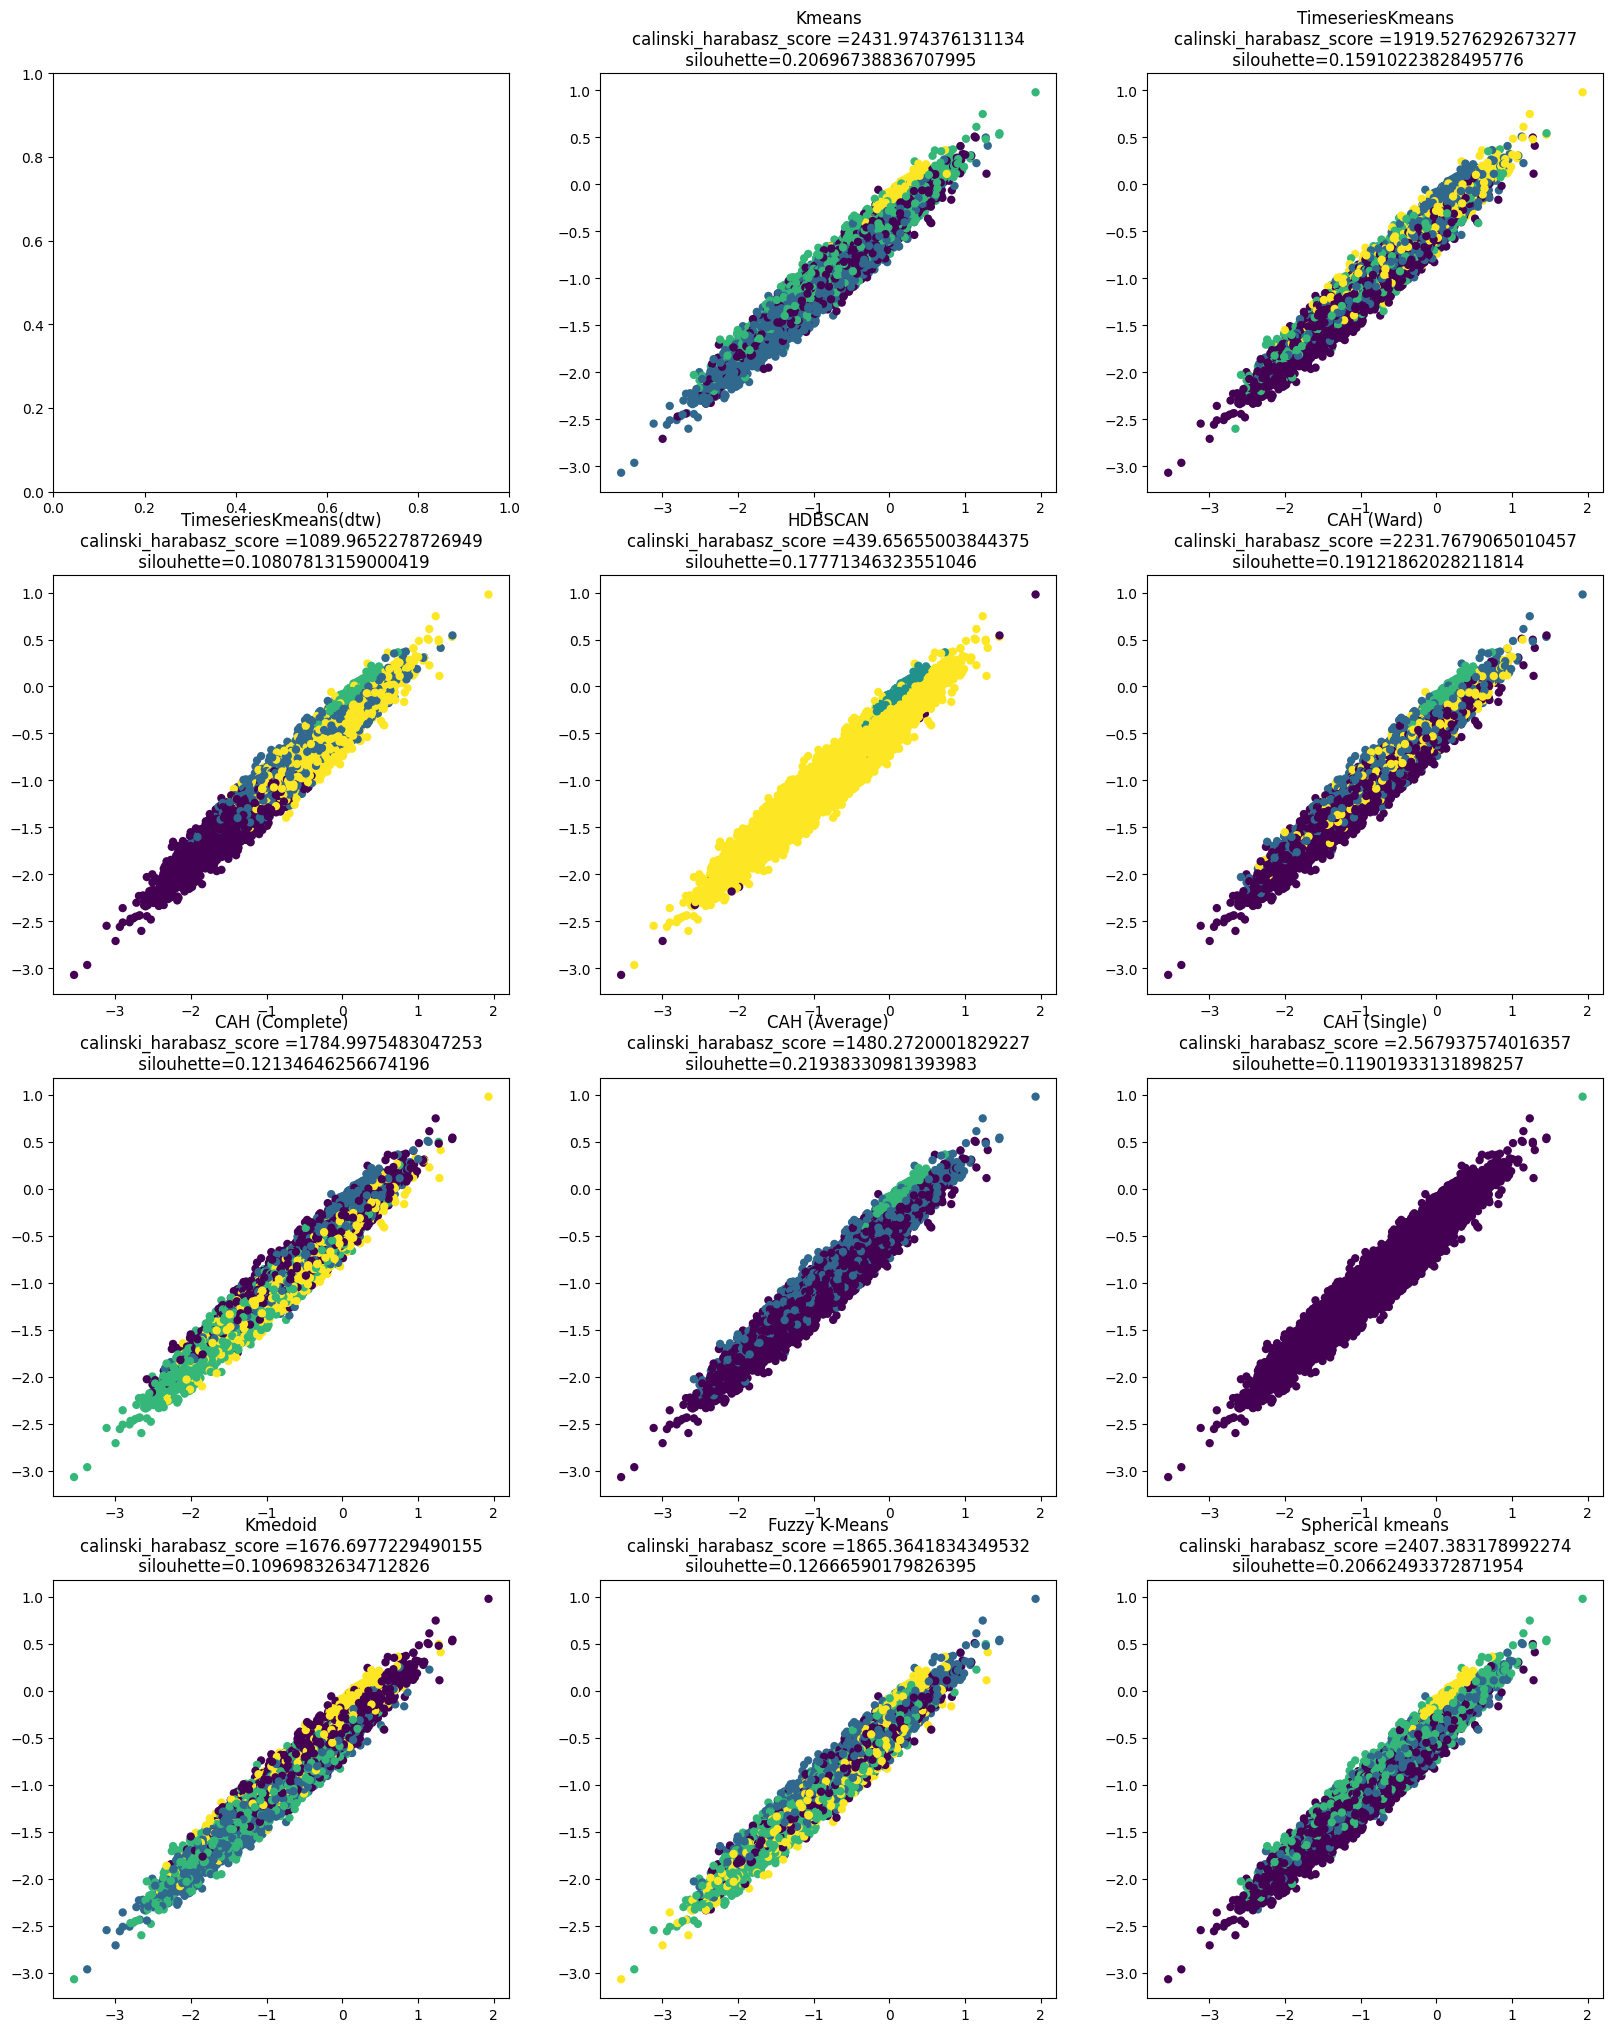

In [ ]:
resultat=run_clustering(X,4)

**Tableau récapitulatif des résultats des méthodes de clustering sur X**

In [ ]:
def table_df(resultat):
  results_temp = deepcopy(resultat)
  for result in results_temp:
          C, S = results_temp[result]
          results_temp[result] = {
              'calinski_harabasz_score': C,
              "silhouette_score": S
          }


  df_resultat = pd.DataFrame(results_temp).T
  return df_resultat

**Comparaison des résultats des méthodes sur X**

In [ ]:
df_resultat=table_df(resultat)
df_resultat

,calinski_harabasz_score,silhouette_score
Kmeans,2431.974376,0.206967
TimeseriesKmeans,1919.527629,0.159102
TimeseriesKmeans(dtw),1089.965228,0.108078
HDBSCAN,439.656550,0.177713
CAH (Ward),2231.767907,0.191219
CAH (Complete),1784.997548,0.121346
CAH (Average),1480.272000,0.219383
CAH (Single),2.567938,0.119019
Kmedoid,1676.697723,0.109698
Fuzzy K-Means,1865.364183,0.126666


Suite à l'application des méthodes de regroupement sur X, nous observons que l'algorithme K-means se distingue comme le meilleur en fonction du score de silhouette et du score de Calinski. De ce fait nous alons utilisons le modèle Kmeans pour predire les clusters (classes) du tableau de données X

**Application du modèle K-means sur X**

In [ ]:
kmeansT = KMeans(n_clusters=4, random_state=42)
kmeansT.fit(X)
labels = kmeansT.labels_
centers = kmeansT.cluster_centers_

In [ ]:
classes = np.unique(labels)

**Calcul de la consommation moyenne d'énergie des appartements pour chaque classe**

In [ ]:
df['class']=labels

In [ ]:
# moyenne de la consommation d'energie des appartements dans le cluster 0
mask=df['class']==0
df.loc[mask].mean(axis=0).mean()

-0.003875060772329986

In [ ]:
## moyenne de la consommation d'energie des appartements dans le cluster 1
mask=df['class']==1
df.loc[mask].mean(axis=0).mean()

0.020477833662291407

In [ ]:
# moyenne de la consommation d'energie des appartements dans le cluster 2
mask=df['class']==2
df.loc[mask].mean(axis=0).mean()

0.044124869678223794

Suite à l'application de l'algorithme K-means sur X, nous avons obtenus 3 clusters (classes) regroupant des appartements présentant une similarité dans leur consommation d'énergie pour divers jours. En se basant sur la moyenne de la consommation d'énergie des appartements de chaque cluster, nous concluons que :

1.   Classe 0 : illustre une faible consommation d'énergie
2.   Classe 1 : illustre une moyenne consommation d'énergie
3.   Classe 2 : illustre une forte consommation d'énergie



**Transformation de X en Y**

Nous avons créé un tableau de données catégorielles Y comprenant 100 lignes (appartements) et 91 colonnes (jours), en utilisant les étiquettes (classes) obtenues après l'application de l'algorithme K-means sur X.

In [ ]:
Y=labels.reshape(100, 91)

In [ ]:
Y_df=pd.DataFrame(Y)
Y_df

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,1,1,1,1,1,2,2,1,1,1,...,0,2,2,1,0,0,1,1,2,2
1,1,1,1,1,1,0,0,1,1,1,...,1,2,2,1,1,1,0,0,2,2
2,3,3,1,1,1,2,3,1,1,1,...,1,2,2,1,1,0,1,1,2,2
3,1,1,1,1,1,2,2,1,1,0,...,0,2,2,0,1,1,1,1,2,2
4,1,1,1,1,1,2,2,1,1,1,...,1,2,2,0,1,1,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1,1,1,1,2,2,1,0,0,...,1,2,2,1,1,1,0,1,2,2
96,1,1,1,1,1,2,0,1,1,1,...,1,0,0,1,1,1,1,1,2,2
97,1,1,1,1,1,2,2,1,1,1,...,0,2,2,1,0,1,1,1,2,2
98,1,1,1,1,1,2,2,1,1,1,...,0,2,2,1,0,1,1,1,2,2


**Dimension de Y (100 Appartement, 91 jours)**

In [ ]:
Y_df.shape

(100, 91)

**Visualisation du tableau de données Y**

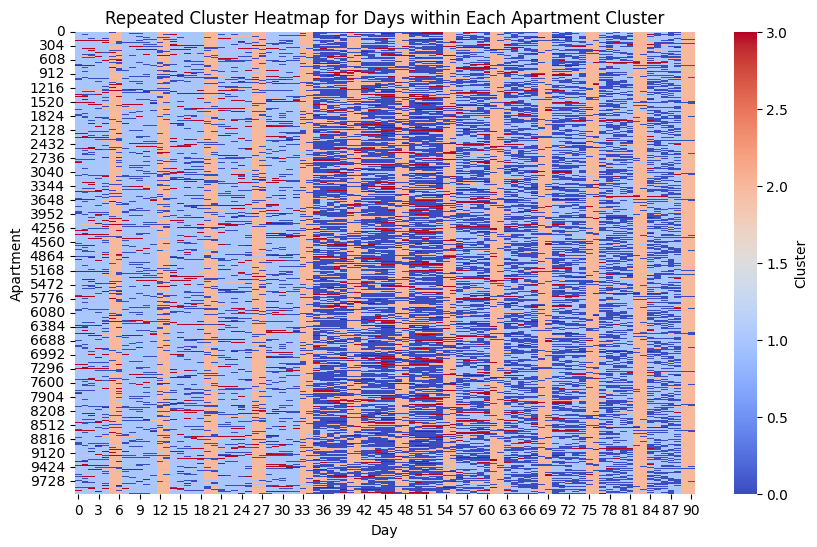

In [ ]:
# Visualize the repeated clusters in a heatmap
plt.figure(figsize=(10, 6))
# Repeat the second-level cluster assignments for each apartment
repeated_cluster_assignments = np.tile(Y, (100, 1))

# Create a new DataFrame for the repeated second-level clusters
result_df_repeated_second_level = pd.DataFrame(repeated_cluster_assignments)

sns.heatmap(result_df_repeated_second_level, cmap='coolwarm', cbar_kws={'label': 'Cluster'})
plt.title('Repeated Cluster Heatmap for Days within Each Apartment Cluster')
plt.xlabel('Day')
plt.ylabel('Apartment')
plt.show()

En examinant la visualisation de Y, nous observons qu'il y a quatre catégories (classes) de consommation d'énergie en fonction des périodes.

- Le fond de la visualisation en orange (entre les barres) correspond au cluster 2, représentant les jours de week-end dont la consommation d’énergie des appartements est élevée.

- Les 32 premiers jours et les 33 dernier jours (barres en bleu clair), séparés par les week-ends, sont associés au cluster 1 (consommation d'énergie moyenne des appartements).

- La période entre le 35e et le 53e jour correspond au cluster 0 dont la consommation d'énergie des appartements est faible.




#**Partie 2 : Classification des jours**

Au sein de cette section, nous procédons actuellement à la classification des 91 jours en utilisant le tableau de données Y.

**Inversement du tableau Y**

Afin d'effectuer cette classification , nous procédons à une inversion des lignes et des colonnes. Ainsi, les jours sont représentés en tant que lignes, tandis que les appartements sont représentés en tant que colonnes.

In [ ]:
Y_T = Y.T

#**Classification du tableau de données Y avec les variables catégorielles**

**Déterminer la valeur de K du modèle K-means**

Pour déterminer la valeur optimale de k dans l’algorithme k-means, nous avons employé trois méthodes : la méthode du coude, la méthode du score silhouette et la méthode du score Davies-Bouldin

**Méthode de coude**

124.198 --> 57.598 --> 55.256 --> 54.221 --> 54.221 --> 
89.484 --> 51.602 --> 50.664 --> 50.523 --> 50.523 --> 
74.099 --> 50.737 --> 50.517 --> 50.517 --> 
82.549 --> 48.468 --> 47.720 --> 47.459 --> 47.258 --> 47.258 --> 
78.264 --> 47.278 --> 46.752 --> 46.041 --> 45.197 --> 44.932 --> 44.295 --> 44.295 --> 
70.242 --> 46.277 --> 46.277 --> 
69.538 --> 44.653 --> 44.484 --> 44.288 --> 43.873 --> 43.720 --> 43.600 --> 43.600 --> 
66.253 --> 43.948 --> 42.813 --> 42.560 --> 42.560 --> 


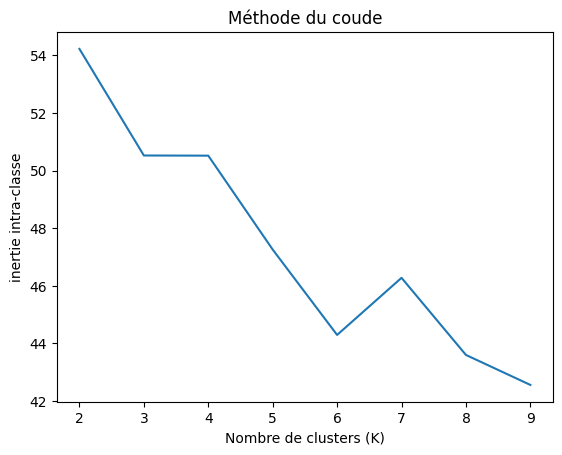

In [ ]:
methode_coude(Y_T,10)

En analysant la courbe de la somme des carrés intra-clusters (WCSS) en fonction du nombre de clusters, nous remarquons un point d'inflexion (le point du coude) au niveau de 3 et 4. Cela suggère que 4 serait le nombre de clusters le plus optimal.

**Méthode de score silouhette**



95.154 --> 54.221 --> 54.221 --> 
91.451 --> 52.109 --> 51.738 --> 51.606 --> 51.537 --> 51.537 --> 
73.747 --> 50.624 --> 50.032 --> 49.865 --> 49.865 --> 
74.758 --> 48.874 --> 48.691 --> 48.632 --> 48.588 --> 48.588 --> 
77.989 --> 45.132 --> 44.755 --> 44.482 --> 44.482 --> 
78.637 --> 45.602 --> 44.884 --> 44.762 --> 44.762 --> 
73.121 --> 45.213 --> 45.019 --> 44.939 --> 44.939 --> 
63.604 --> 41.581 --> 41.125 --> 40.986 --> 40.986 --> 


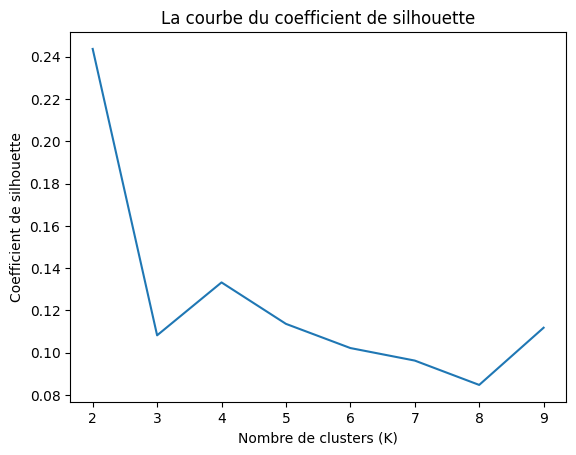

In [ ]:
K_silhouette(Y_T,10)

En analysant la courbe des scores de silhouette en fonction du nombre de clusters, nous remarquons que le nombre de clusters optimal, k, correspond au score de silhouette le plus élevé, qui est de 0.24 et 0.14. Par conséquent, nous pouvons conclure que k=4 serait le nombre de clusters approprié (optimal).

**Méthode de score davies_bouldin**

99.484 --> 54.221 --> 54.221 --> 
96.484 --> 51.011 --> 50.523 --> 50.523 --> 
77.637 --> 51.066 --> 50.730 --> 50.530 --> 50.177 --> 49.963 --> 49.449 --> 48.594 --> 47.961 --> 47.784 --> 47.784 --> 
78.714 --> 49.387 --> 47.623 --> 46.862 --> 46.507 --> 46.443 --> 46.381 --> 46.229 --> 46.112 --> 46.112 --> 
74.407 --> 46.604 --> 45.901 --> 45.746 --> 45.746 --> 
65.484 --> 46.548 --> 45.260 --> 44.933 --> 44.527 --> 44.370 --> 44.319 --> 44.319 --> 
65.967 --> 42.367 --> 41.597 --> 41.384 --> 41.262 --> 41.155 --> 41.155 --> 
64.198 --> 43.368 --> 42.810 --> 42.713 --> 42.658 --> 42.658 --> 


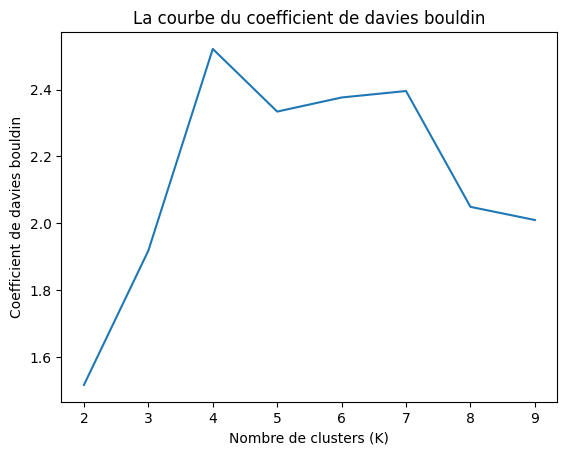

In [ ]:
davies_bouldin(Y_T,10)

D'après la courbe des scores de Davies-Bouldin en relation avec le nombre de clusters, nous observons que le nombre optimal de clusters \(k\) correspond à \(k=4\).

**Application des méthodes de clustering sur Y avec les variables catégorielles**

Dans cette section, nous avons employé divers algorithmes de regroupement tels que le K-menas, le K-means TimeSeries, le k-medoid, le Hdbscan, le fuzzy k-means, le spherical k-means, ainsi que les algorithmes CAH avec différents critères (Ward, Complete, Average et Single). Ensuite, nous avons réalisé la classification des jours en utilisant l’algorithme qui a démontré la meilleure performance selon les scores silhouette et Ca-linski Harabasz.



71.538 --> 51.838 --> 51.286 --> 51.181 --> 50.978 --> 50.922 --> 50.922 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


20.275 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


15.151 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


14.928 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


14.658 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


14.617 --> 14.617 --> 

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


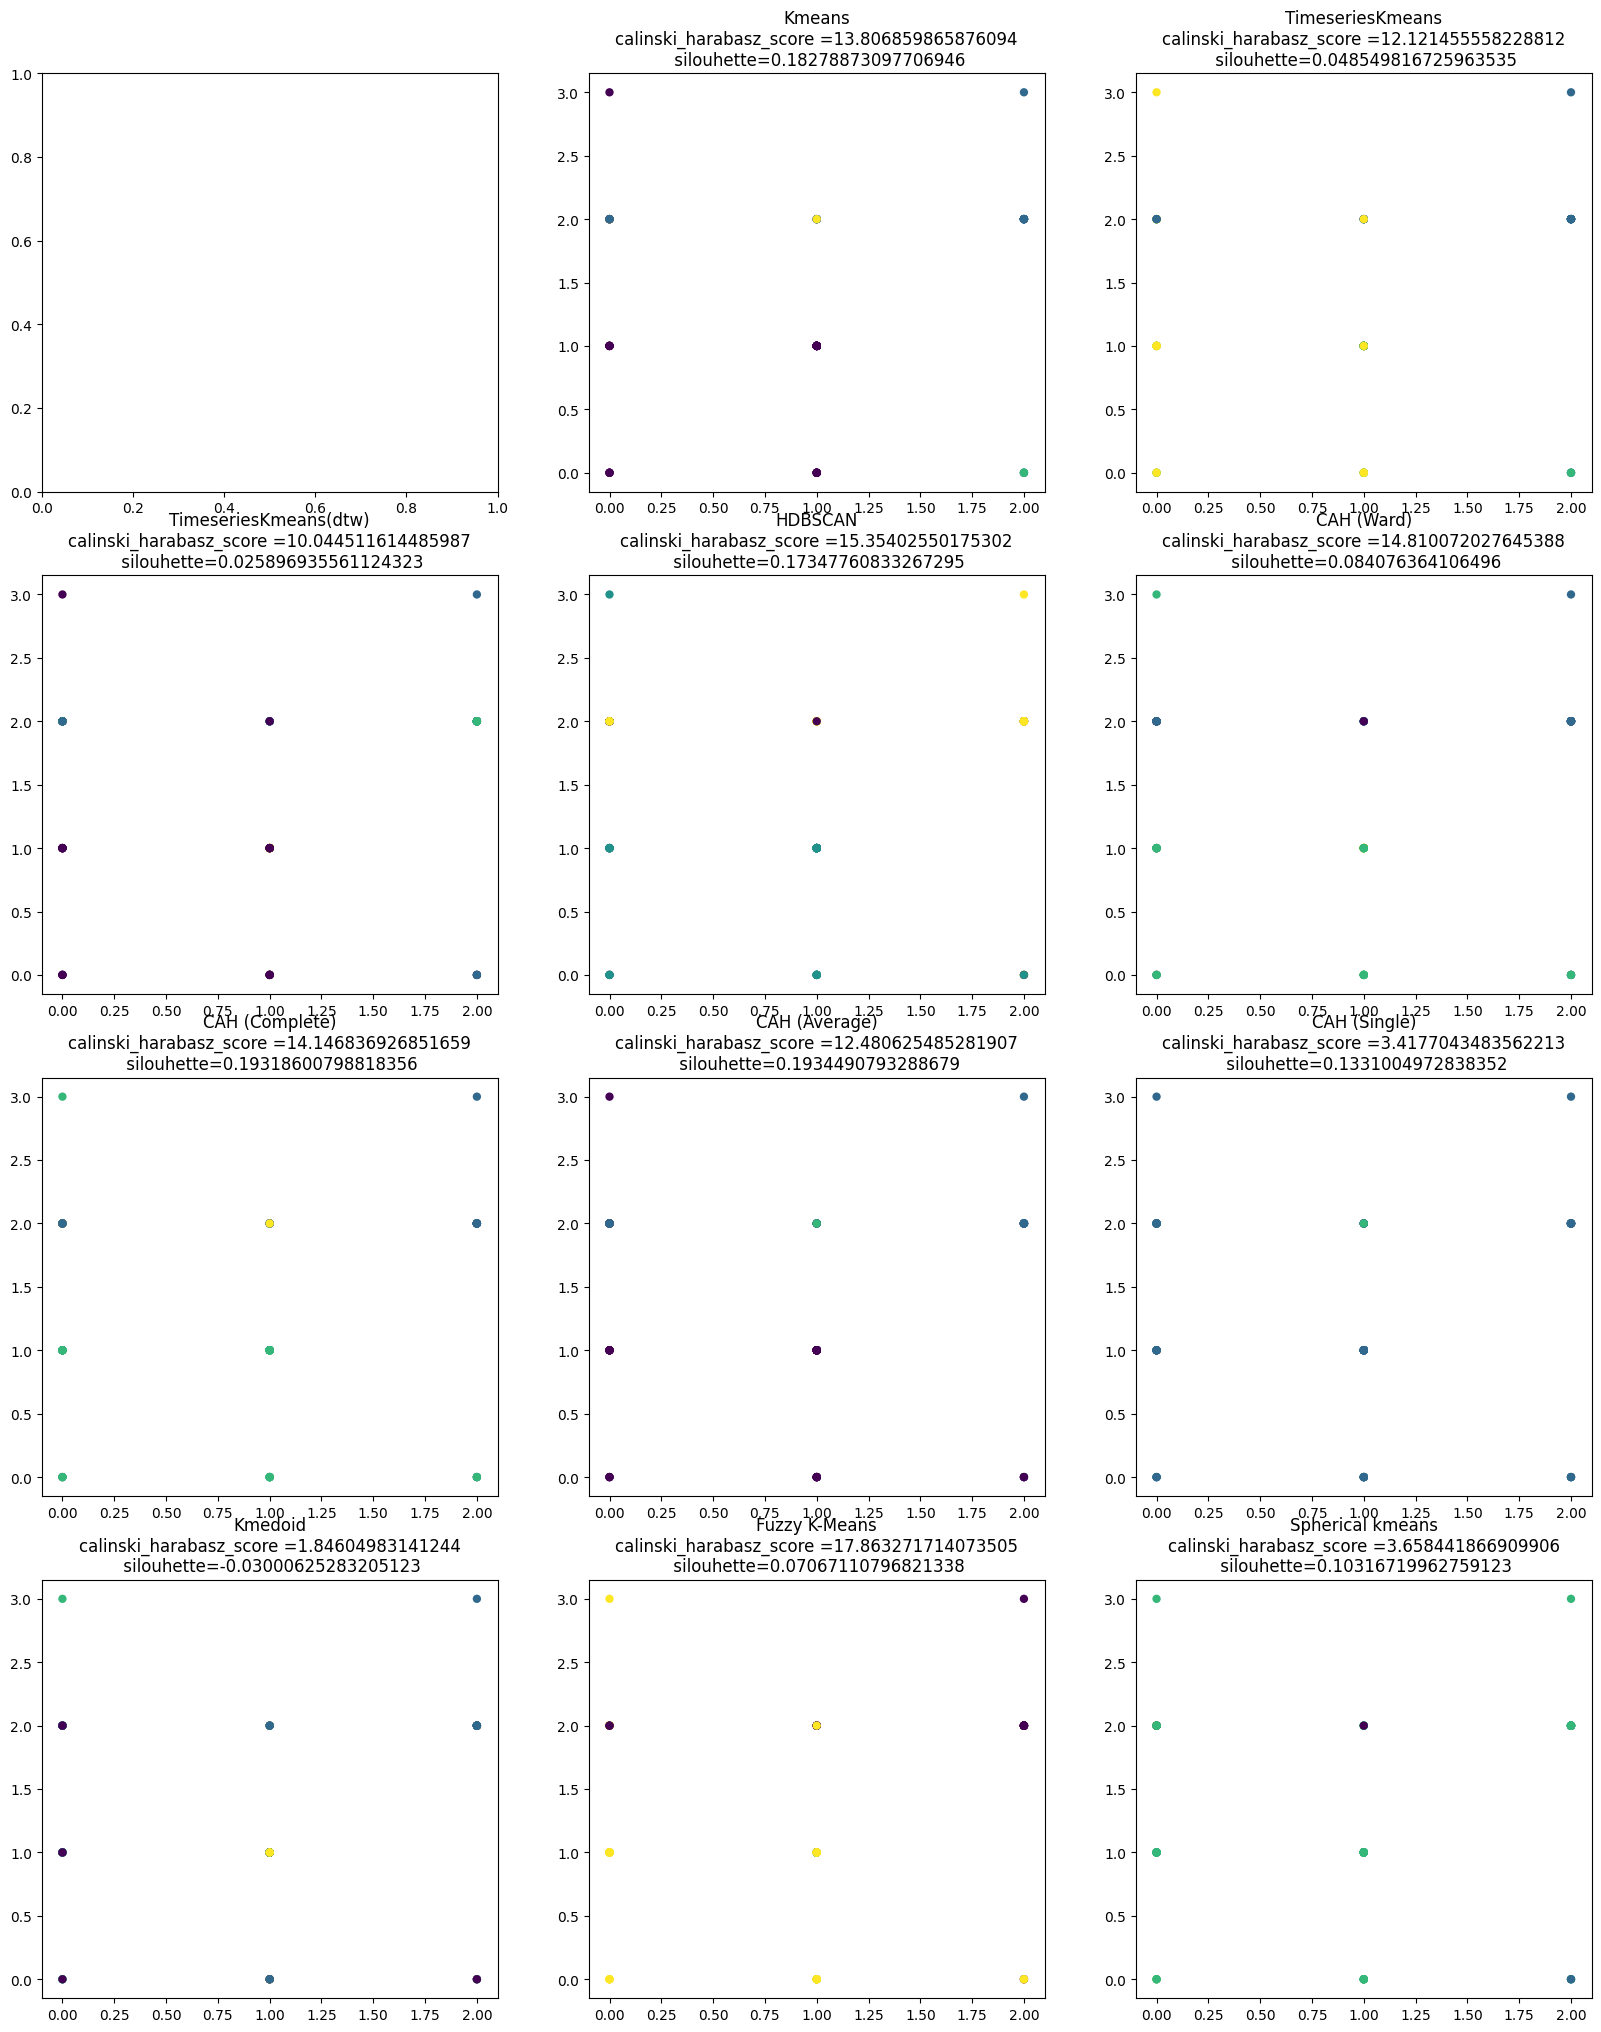

In [ ]:
resultat_Y=run_clustering(Y_T,4)

**Tableau récapitulatif des résultats**

In [ ]:
resultat_y_df=table_df(resultat_Y)
resultat_y_df

,calinski_harabasz_score,silhouette_score
Kmeans,13.806860,0.182789
TimeseriesKmeans,12.121456,0.048550
TimeseriesKmeans(dtw),10.044512,0.025897
HDBSCAN,15.354026,0.173478
CAH (Ward),14.810072,0.084076
CAH (Complete),14.146837,0.193186
CAH (Average),12.480625,0.193449
CAH (Single),3.417704,0.133100
Kmedoid,1.846050,-0.030006
Fuzzy K-Means,17.863272,0.070671


Après avoir appliqué les méthodes de regroupement sur Y, nous constatons que les algorithmes K-means avec k=4 et CAH (complete) se démarquent comme les meilleurs avec des scores de silhouette dépassant respectivement 0,18 et 0,19, ainsi qu’un score de Calinski dépassant respectivement 13,80 et 14,14.

**Application de k-means sur Y catégorielle**

In [ ]:
kmeansT= KMeans(n_clusters=4, random_state=42)
kmeansT.fit(Y_T)
labels_Yc=kmeansT.labels_

**Visualisation des résultats**

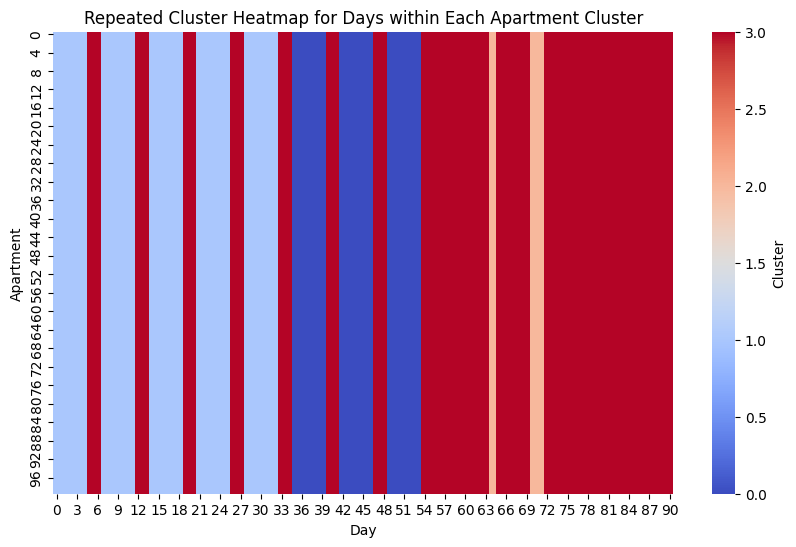

In [ ]:
# Visualize the repeated clusters in a heatmap
plt.figure(figsize=(10, 6))
# Repeat the second-level cluster assignments for each apartment
repeated_cluster_assignments = np.tile(labels_Yc, (100, 1))

# Create a new DataFrame for the repeated second-level clusters
result_df_repeated_second_level = pd.DataFrame(repeated_cluster_assignments)

sns.heatmap(result_df_repeated_second_level, cmap='coolwarm', cbar_kws={'label': 'Cluster'})
plt.title('Repeated Cluster Heatmap for Days within Each Apartment Cluster')
plt.xlabel('Day')
plt.ylabel('Apartment')
plt.show()

En analysant la visualisation des résultats de l’algorithme de clustering K-means sur Y, nous distinguons quatre catégories (classes) de jours en fonction de la consommation d’énergie.

-Le fond de la visualisation correspond au cluster 3, qui représente les jours de week-end (entre les barres) et les vacances, où la consommation d’énergie est très élevée.

-Les 32 premiers jours (5 barres en bleu clair) sont associés au cluster 1 (consom-mation d’énergie moyenne).

-La période entre le 34e et le 53e jour (3 barres en bleu) correspond au cluster 0, où les jours dont la consommation d’énergie est faible.

-Les jours 63e, 69e, 70e et 71e (barres en orange clair) appartiennent au cluster 2,
représentant les jours où la consommation d’énergie est élevée





**Application de CAH(complete) sur Y catégorielle**

In [ ]:
labels_Yc= AgglomerativeClustering(n_clusters=4, linkage="complete").fit_predict(Y_T)

**Visualisation des résultats**

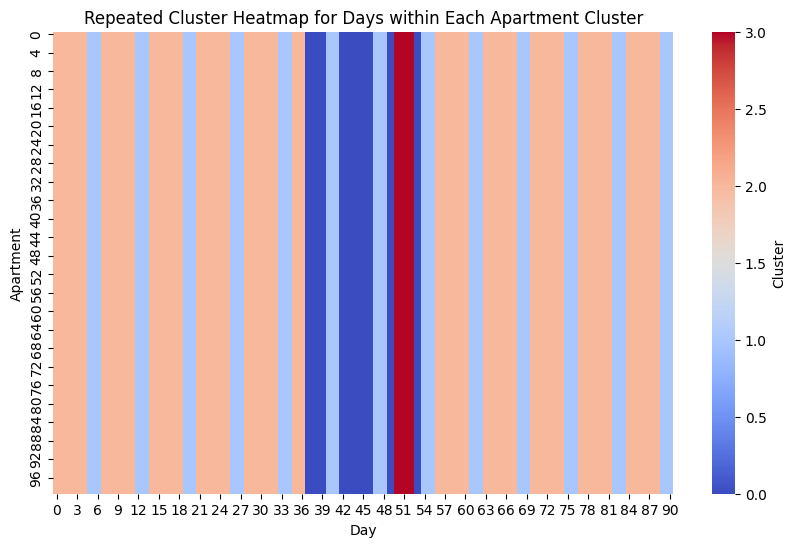

In [ ]:
# Visualize the repeated clusters in a heatmap
plt.figure(figsize=(10, 6))
# Repeat the second-level cluster assignments for each apartment
repeated_cluster_assignments = np.tile(labels_Yc, (100, 1))

# Create a new DataFrame for the repeated second-level clusters
result_df_repeated_second_level = pd.DataFrame(repeated_cluster_assignments)

sns.heatmap(result_df_repeated_second_level, cmap='coolwarm', cbar_kws={'label': 'Cluster'})
plt.title('Repeated Cluster Heatmap for Days within Each Apartment Cluster')
plt.xlabel('Day')
plt.ylabel('Apartment')
plt.show()

En examinant la visualisation des résultats de l’algorithme CAH (complete) sur Y, nous identifions quatre catégories (classes) de jours en fonction de la consommation d’énergie.

- Le fond de la visualisation correspond au cluster 1, représentant les jours de week-end (entre les barres) dont la consommation d’énergie est moyenne.
- Les 36 premiers jours et les 34 derniers jours (barres en orange clair), séparés par les week-ends, sont associés au cluster 2 (consommation d’énergie élevée).
- La période entre le 37e et le 50e jour (3 barres en bleu) séparés par les week-end, correspond au cluster des jours 0 (faible consommation d’énergie).

- La barre rouge représente les jours du 50e au 52e, appartenant au cluster 3 dont la consommation d’énergie est très élevée.

#**Classification du tableau de données Y encodé en variables quantitatives**

**Applicationn de la technique Onehotencoding sur Y**

Pour réaliser la classification des jours sur Y avec des données continues, nous entreprenons l’encodage ou la conversion des données catégorielles du tableau Y en données numériques(continues) en utilisant la technique de codage one-hot (OneHotEncoding).

Nous avons employé la technique de codage one-hot (OneHotEncoding) pour convertir les valeurs catégorielles de Y (0, 1 et 2) en valeurs numériques.

In [ ]:
# Initialiser l'encodeur one-hot
onehot_encoder = OneHotEncoder(sparse=False)
# Appliquer l'encodage one-hot sur la colonne catégorielle
Y_encoded = onehot_encoder.fit_transform(Y_T)


**Dimensions de Y encodé**

In [ ]:
Y_encoded.shape

(91, 394)

In [ ]:
Y_df_endoded=pd.DataFrame(Y_encoded)

**Déterminer la valeur de K pour le modèle Kmeans**

**Méthode de coude**

Initialization complete
Iteration 0, inertia 7366.0.
Iteration 1, inertia 4364.753846153846.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8054.0.
Iteration 1, inertia 4536.914957064244.
Iteration 2, inertia 4404.045645823254.
Iteration 3, inertia 4364.753846153846.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9788.0.
Iteration 1, inertia 4364.753846153846.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9708.0.
Iteration 1, inertia 4609.337660234161.
Iteration 2, inertia 4605.634146341465.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9416.0.
Iteration 1, inertia 4615.89427749985.
Iteration 2, inertia 4605.634146341465.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7596.0.
Iteration 1, inertia 4382.2526455026455.
Iteration 2, inertia 4364.753846153846.
Converged at

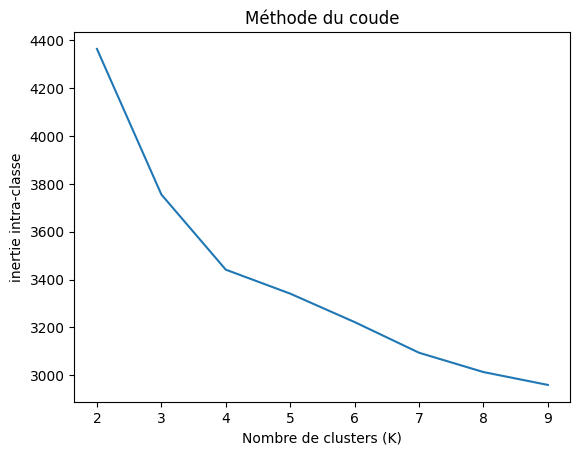

In [ ]:
methode_coude(Y_encoded,10)

En analysant la courbe de la somme des carrés intra-clusters (WCSS) en fonction du nombre de clusters, nous remarquons un point d'inflexion (le point du coude) au niveau de 3 et 4. Cela suggère que 4 serait le nombre de clusters le plus optimal.

**Méthode de score de silhouette**

Initialization complete
Iteration 0, inertia 7856.0.
Iteration 1, inertia 4382.421390778533.
Iteration 2, inertia 4364.753846153846.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7494.0.
Iteration 1, inertia 4364.753846153846.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10878.0.
Iteration 1, inertia 5022.298350634372.
Iteration 2, inertia 4615.63731333754.
Iteration 3, inertia 4605.634146341465.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 8374.0.
Iteration 1, inertia 4364.753846153846.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9524.0.
Iteration 1, inertia 4609.337660234161.
Iteration 2, inertia 4605.634146341465.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7994.0.
Iteration 1, inertia 4364.753846153846.
Converged at iteration 1: strict convergence.
Initia

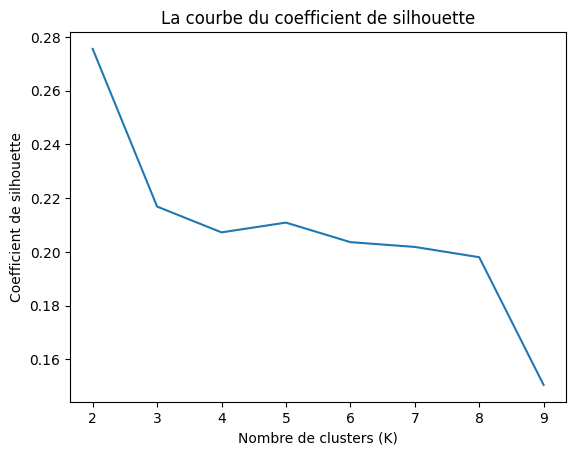

In [ ]:
K_silhouette(Y_encoded,10)

En analysant la courbe des scores de silhouette en fonction du nombre de clusters, nous remarquons que le nombre de clusters optimal, k, correspond au score de silhouette le plus élevé, qui est de 0.22 et 0.20. Par conséquent, nous pouvons conclure que k=4 serait le nombre de clusters approprié (optimal).

**Méthode de score de davies bouldin**

85.978 --> 48.447 --> 48.065 --> 48.065 --> 
78.242 --> 42.076 --> 42.007 --> 41.923 --> 41.853 --> 41.853 --> 
79.846 --> 40.015 --> 39.612 --> 39.356 --> 38.963 --> 38.881 --> 38.761 --> 38.332 --> 37.938 --> 37.938 --> 
68.681 --> 38.571 --> 37.523 --> 36.973 --> 36.850 --> 36.850 --> 
67.121 --> 36.459 --> 35.693 --> 35.557 --> 35.557 --> 
62.791 --> 35.979 --> 35.772 --> 35.599 --> 35.599 --> 
60.857 --> 34.751 --> 34.442 --> 34.282 --> 34.201 --> 34.201 --> 
61.099 --> 32.740 --> 32.234 --> 32.234 --> 


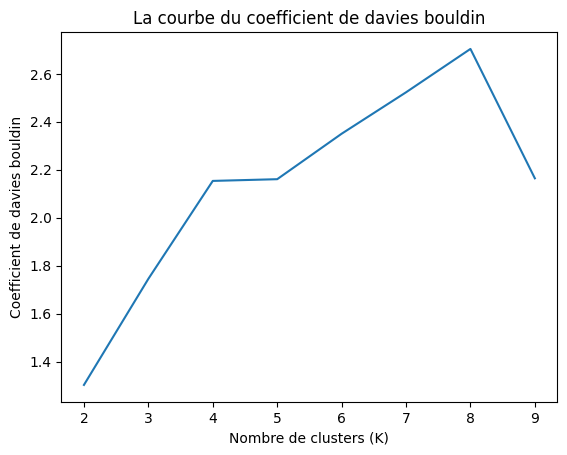

In [ ]:
davies_bouldin(Y_encoded,10)

D'après la courbe des scores de Davies-Bouldin en relation avec le nombre de clusters, nous observons que le nombre optimal de clusters \(k\) correspond à \(k=4\).

**Application des méthodes de clustering sur Y avec les variables continues**

De manière similaire à ce que nous avons fait avec le tableau Y catégoriel, nous avons appliqué divers algorithmes de regroupement sur Y encodé, notamment le K-menas, le K-means TimeSeries, le k-medoid, le Hdbscan, le fuzzy k-means, le spherical k-means, ainsi que les algorithmes CAH avec différents critères (Ward, Complete, Average et Single). Par la suite, nous avons procédé à la classification des jours en utilisant l’algorithme qui a démontré la meilleure performance selon les scores silhouette et Calinski Harabasz



73.670 --> 40.736 --> 40.736 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


0.714 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


0.507 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


0.507 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


0.507 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


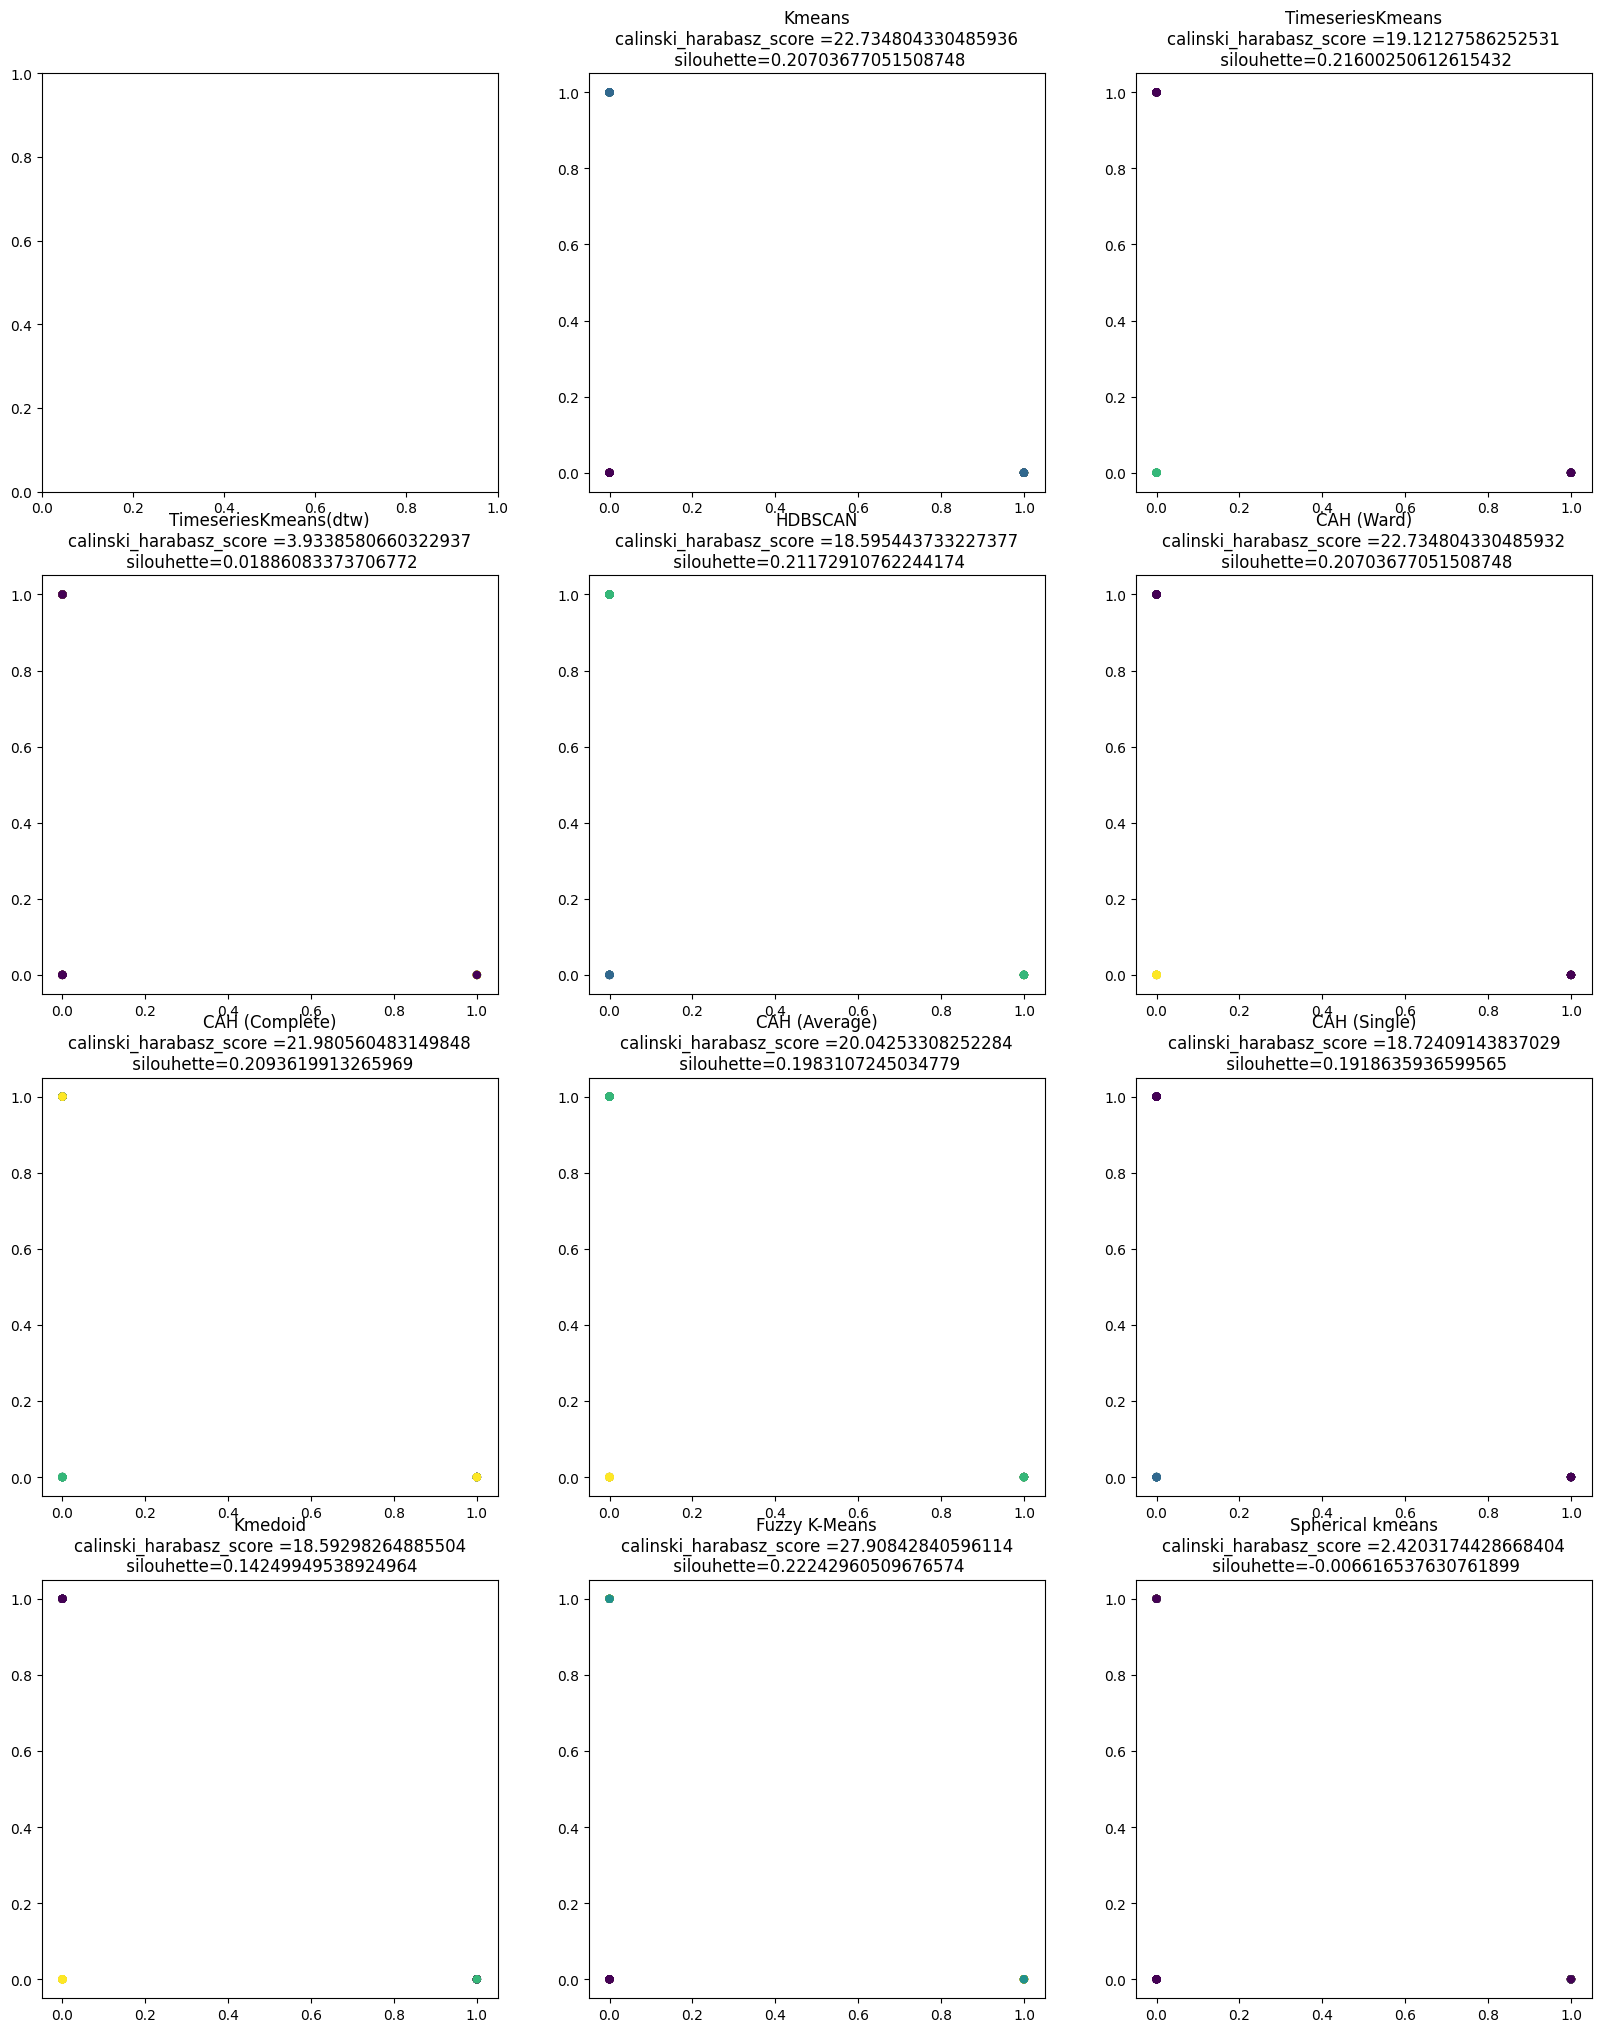

In [ ]:
resultat_YE=run_clustering(Y_encoded,4)

**Tableau récapitulatif des résultats**

In [ ]:
resultat_ye_df=table_df(resultat_YE)
resultat_ye_df

,calinski_harabasz_score,silhouette_score
Kmeans,22.734804,0.207037
TimeseriesKmeans,19.121276,0.216003
TimeseriesKmeans(dtw),3.933858,0.018861
HDBSCAN,18.595444,0.211729
CAH (Ward),22.734804,0.207037
CAH (Complete),21.980560,0.209362
CAH (Average),20.042533,0.198311
CAH (Single),18.724091,0.191864
Kmedoid,18.592983,0.142499
Fuzzy K-Means,27.908428,0.222430


selon les résultats dans le tableau ci-dessus, nous constatons que les algorithmes K-means avec k=4 et fuzzy k-means se démarquent comme les meilleurs, avec des scores de silhouette dépassant respectivement 0,20 et 0,22, ainsi qu’un score de Calinski dépassant respectivement 22 et 27.



**Application K-means**

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(Y_encoded)
labels_Ye = kmeans.labels_
centers = kmeans.cluster_centers_

**Visualisation des résultats**

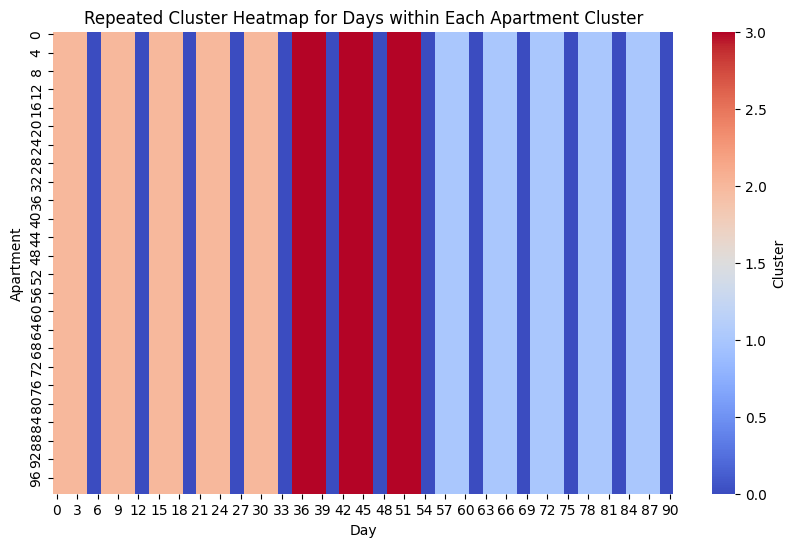

In [ ]:
# Visualize the repeated clusters in a heatmap
plt.figure(figsize=(10, 6))
# Repeat the second-level cluster assignments for each apartment
repeated_cluster_assignments = np.tile(labels_Ye, (100, 1))

# Create a new DataFrame for the repeated second-level clusters
result_df_repeated_second_level = pd.DataFrame(repeated_cluster_assignments)

sns.heatmap(result_df_repeated_second_level, cmap='coolwarm', cbar_kws={'label': 'Cluster'})
plt.title('Repeated Cluster Heatmap for Days within Each Apartment Cluster')
plt.xlabel('Day')
plt.ylabel('Apartment')
plt.show()


En examinant la visualisation des résultats de l’algorithme K-means sur Y encodé,nous identifions quatre catégories (classes) de jours en fonction de la consommation d’énergie.

-Le fond de la visualisation en bleu (entre les barres) correspond au cluster 0, représentant les jours de week-end dont la consommation d’énergie est faible.

-Les 32 premiers jours (barres en orange), séparés par les week-ends, sont associés au cluster 2 (consommation d’énergie élevée).

-La période entre le 35e et le 53e jour (3 barres en rouge) correspond au cluster 3 dont la consommation d’energie des cette periode est trés élevée.

-Les barres en bleu clair représentent les jours du 56e au 89e, appartenant au cluster 1 dont la consommation d’énergie est moyenne.



